# Project Four: Part Four

### Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import xlrd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from pmdarima.arima import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller


### Open Pickled Dataframe

In [4]:
kings_grouped = pd.read_pickle("./kings_grouped.pkl")

### ACF PACF Function

In [5]:
# acf and pacf function

def plot_acf_pacf(ts, figsize=(10,8), lags = 24, zipcode = 'add'):
    
    fig,ax = plt.subplots(nrows=3,
                         figsize = figsize)
    
    #plot time series
    ts.plot(ax=ax[0])
    
    #plot acf, pacf
    plot_acf(ts,ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags)
    fig.tight_layout()
    
    fig.suptitle(f'Zipcode: {zipcode}',y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=lags, integer = True))
        a.xaxis.grid()
    return fig,ax

### 11203

In [6]:
two_zero_three = kings_grouped.loc[11203]

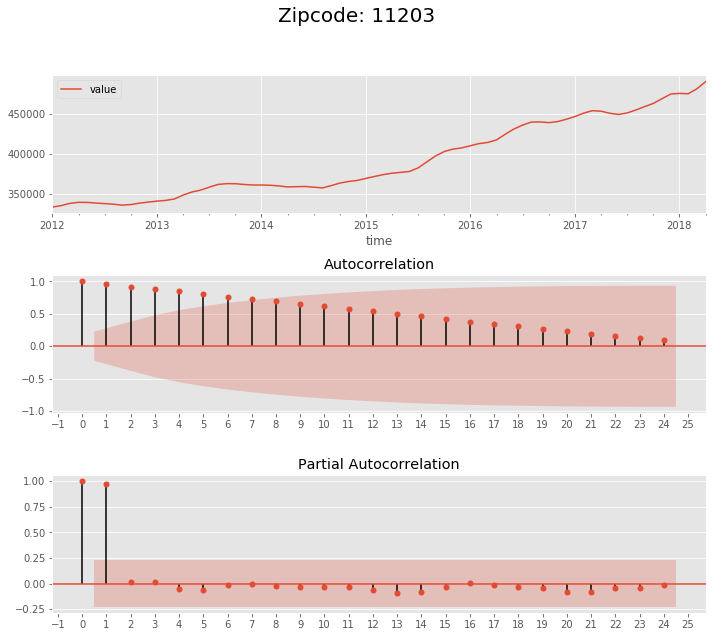

In [7]:
plot_acf_pacf(two_zero_three, zipcode = '11203')
plt.show()

### Decompose Time Series

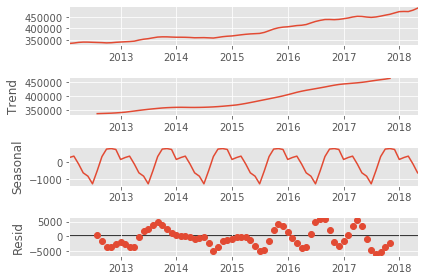

In [8]:
decompose_result = seasonal_decompose(two_zero_three, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

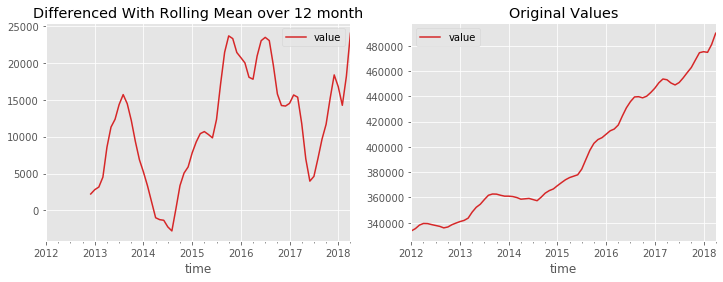

In [10]:
rolling_mean = two_zero_three.rolling(window = 12).mean()
two_zero_three_rolled_detrended = two_zero_three - rolling_mean

ax1 = plt.subplot(121)
two_zero_three_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_zero_three.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [11]:
dftest = adfuller(two_zero_three_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.3901406615646303
2. P-Value :  0.5869935758357413
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315


### Using Differencing with Mean Rolled Time Series for Seasonality

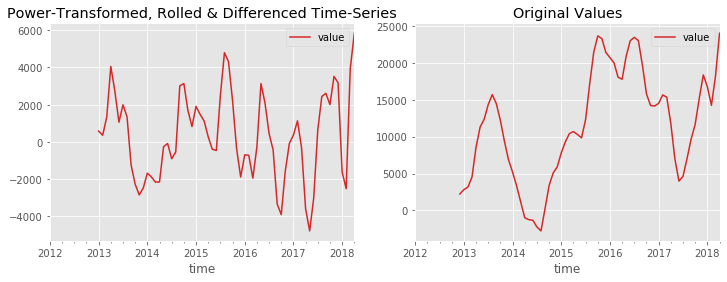

In [13]:
two_zero_three_rolled_detrended_diff = two_zero_three_rolled_detrended - two_zero_three_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_zero_three_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_zero_three_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [15]:
two_zero_three = two_zero_three_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [16]:
dftest = adfuller(two_zero_three.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.44641866999394
2. P-Value :  0.12906122287711685
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315


### Parameter Selection

In [17]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_zero_three, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [19]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           881.902
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

In [21]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_zero_three, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7378      0.127      5.792      0.000       0.488       0.987
ma.S.L12      -1.1516      0.857     -1.344      0.179      -2.831       0.528
sigma2      2.575e+06   2.56e+06      1.007      0.314   -2.44e+06    7.59e+06


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

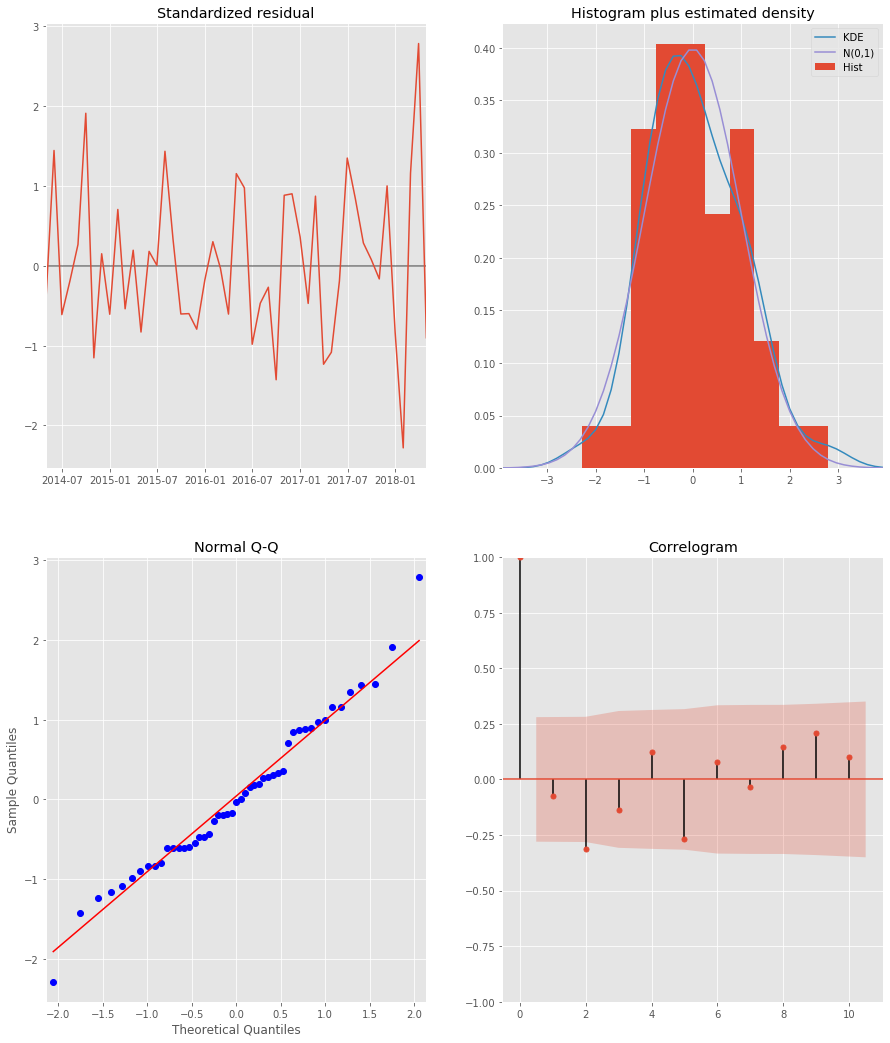

In [22]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [23]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

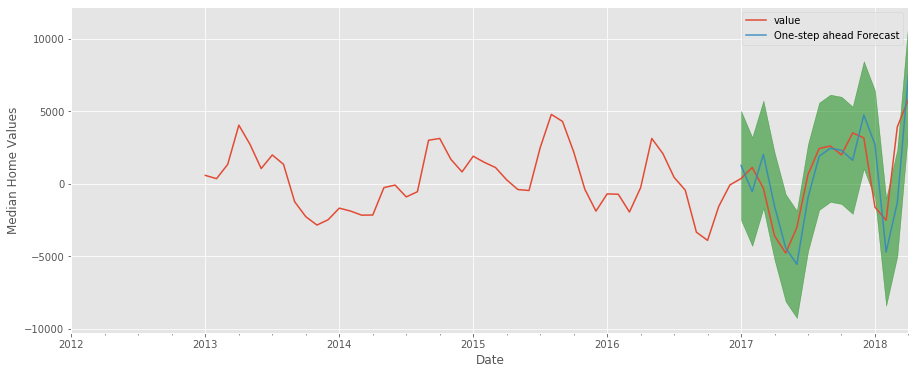

In [24]:

rcParams['figure.figsize'] = 15, 6

ax = two_zero_three['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [25]:
val_forecasted = pred.predicted_mean
val_truth = two_zero_three.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5159166.44


### Model Validation - Dynamic Forecasting

In [26]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

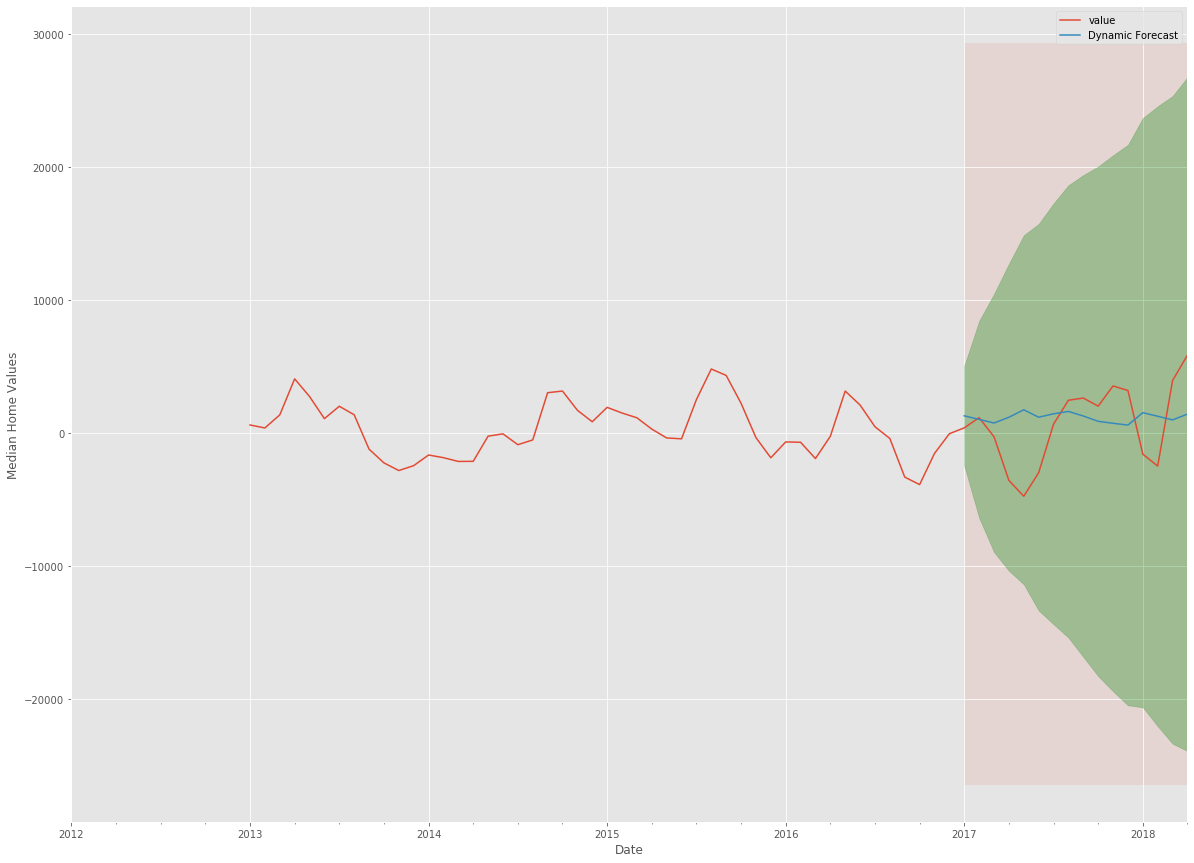

In [27]:
ax = two_zero_three['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [28]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_zero_three.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 9710250.61


### Visualizing Confidence Interval

In [29]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

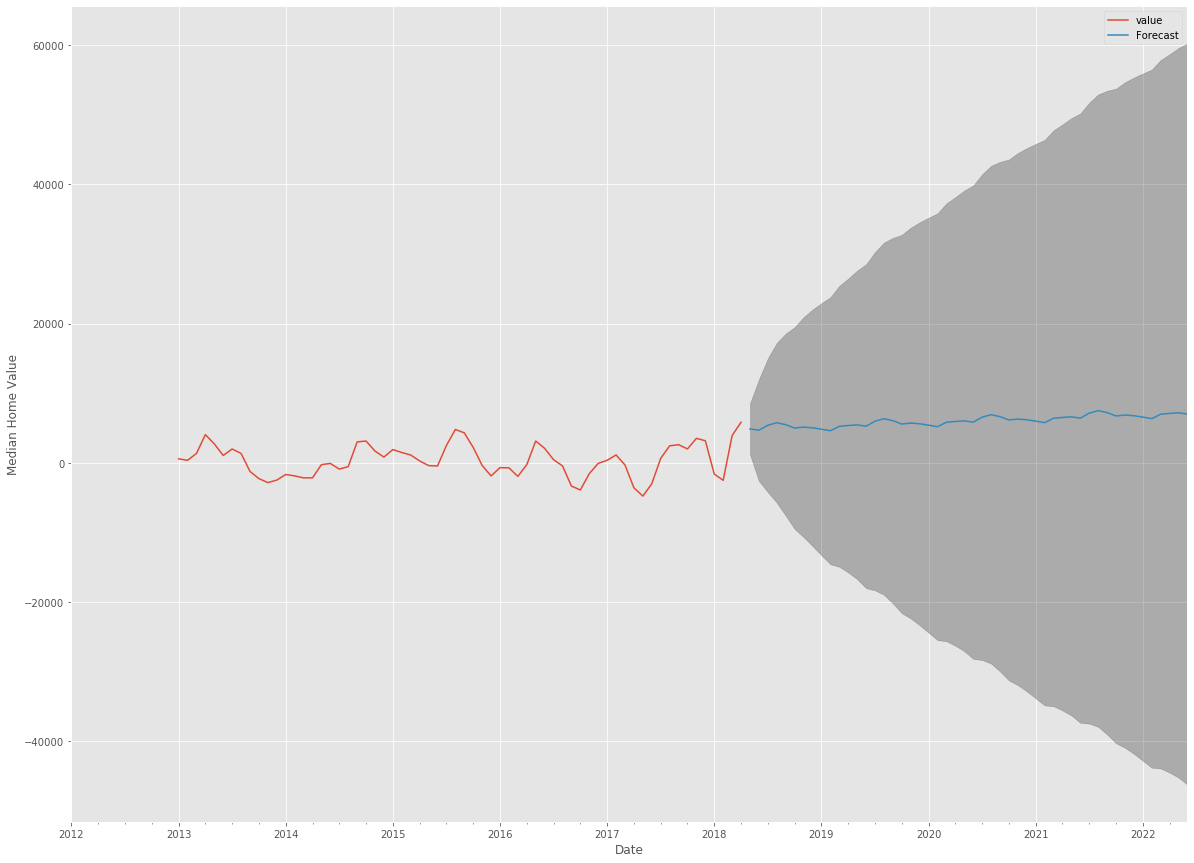

In [30]:
ax = two_zero_three.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11203 Conclusion: 

### 11220

In [31]:
two_two_zero = kings_grouped.loc[11220]

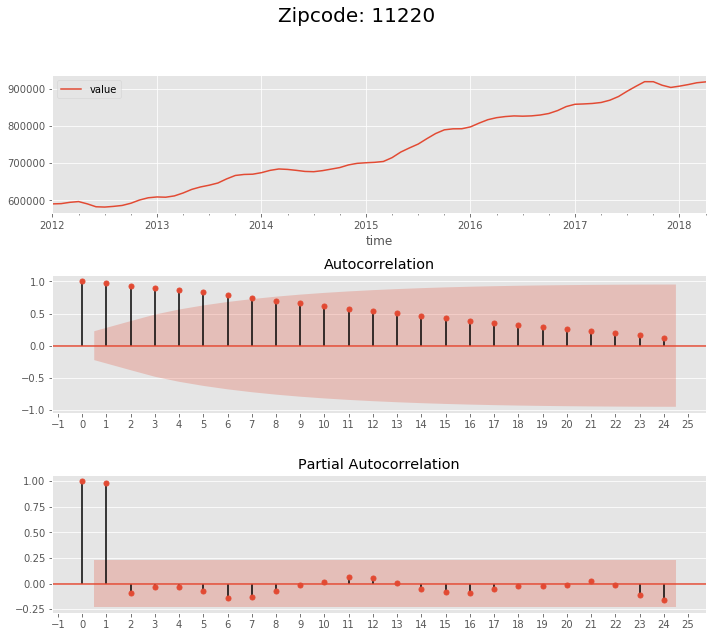

In [32]:
plot_acf_pacf(two_two_zero, zipcode = '11220')
plt.show()

### Decompose Time Series

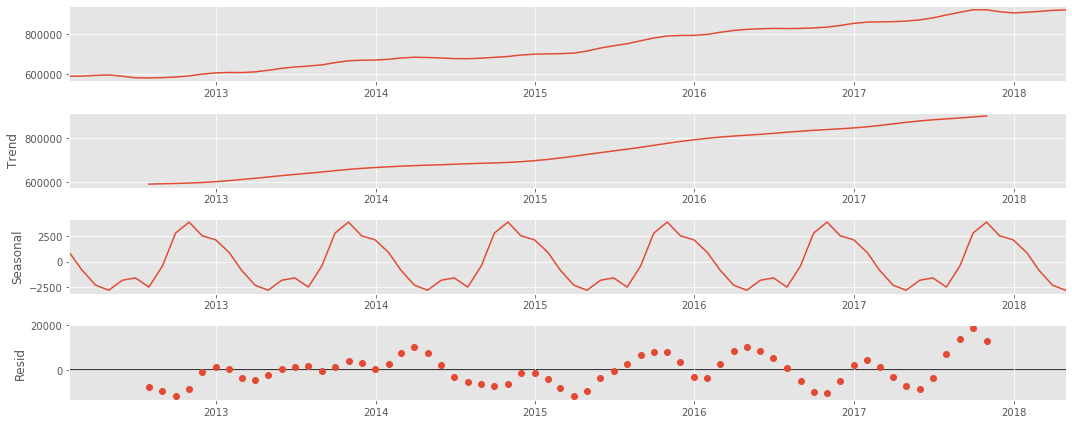

In [33]:
decompose_result = seasonal_decompose(two_two_zero, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

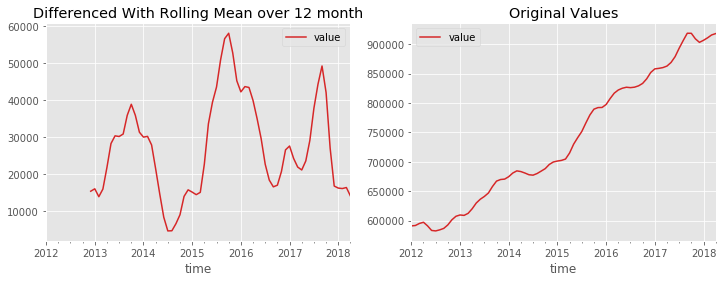

In [35]:
rolling_mean = two_two_zero.rolling(window = 12).mean()
two_two_zero_rolled_detrended = two_two_zero - rolling_mean

ax1 = plt.subplot(121)
two_two_zero_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_two_zero.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [36]:
dftest = adfuller(two_two_zero_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.7544109160010901
2. P-Value :  0.4033185588517361
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Using Differencing with Mean Rolled Time Series for Seasonality

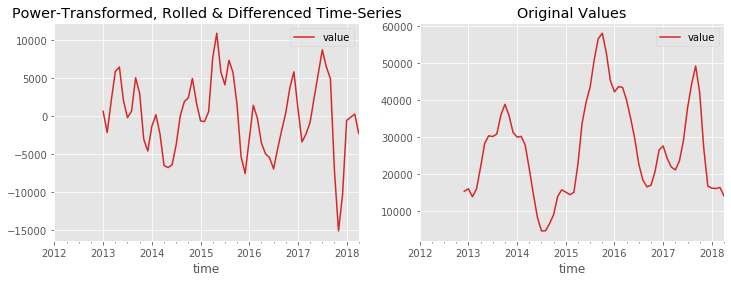

In [37]:
two_two_zero_rolled_detrended_diff = two_two_zero_rolled_detrended - two_two_zero_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_two_zero_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_two_zero_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [38]:
two_two_zero = two_two_zero_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

In [39]:
dftest = adfuller(two_two_zero.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.9999809201069345
2. P-Value :  0.0014106111642498622
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 52
5. Critical Values :
	 1% :  -3.562878534649522
	 5% :  -2.918973284023669
	 10% :  -2.597393446745562


In [40]:
two_two_zero_diff = two_two_zero.diff().dropna()
two_two_zero_diff.head()

value
time                   
2013-02-28 -2783.333333
2013-03-31  4200.000000
2013-04-30  3816.666667
2013-05-31   583.333333
2013-06-30 -4391.666667

### ACF & PACF with Differenced Dataframe

These can be used to better understand the AR & MA components.

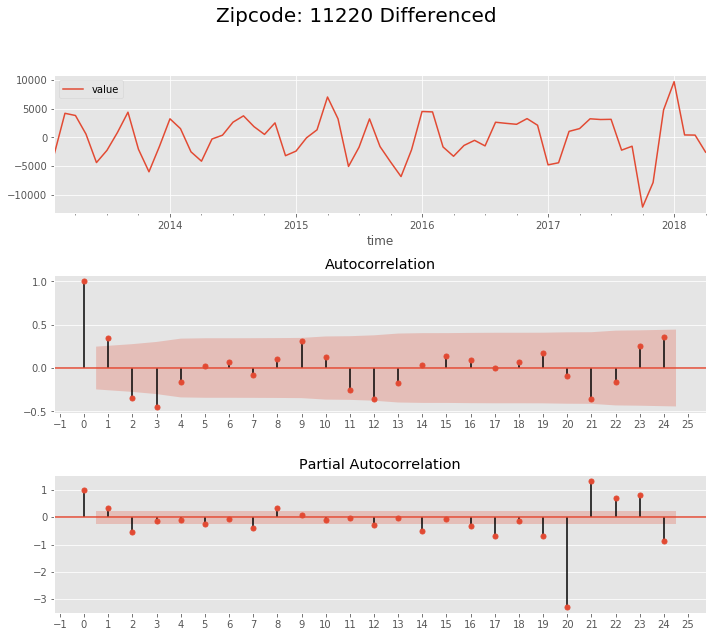

In [41]:
plot_acf_pacf(two_two_zero_diff, zipcode = '11220 Differenced')
plt.show()

### Parameter Selection

In [42]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [43]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_two_zero, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [44]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           935.313
Name: 31, dtype: object

### Fitting the Time Series Model - ARIMA

COMMENTS ON THE P VALUES - LOW P VAL = GOOD 

In [45]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_two_zero, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3876      0.180      2.154      0.031       0.035       0.740
ar.S.L12      -0.6189      0.178     -3.479      0.001      -0.968      -0.270
ma.S.L12      -1.3163      0.375     -3.514      0.000      -2.050      -0.582
sigma2      5.607e+06   3.13e+06      1.793      0.073   -5.22e+05    1.17e+07


### Plot Diagnostics


1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

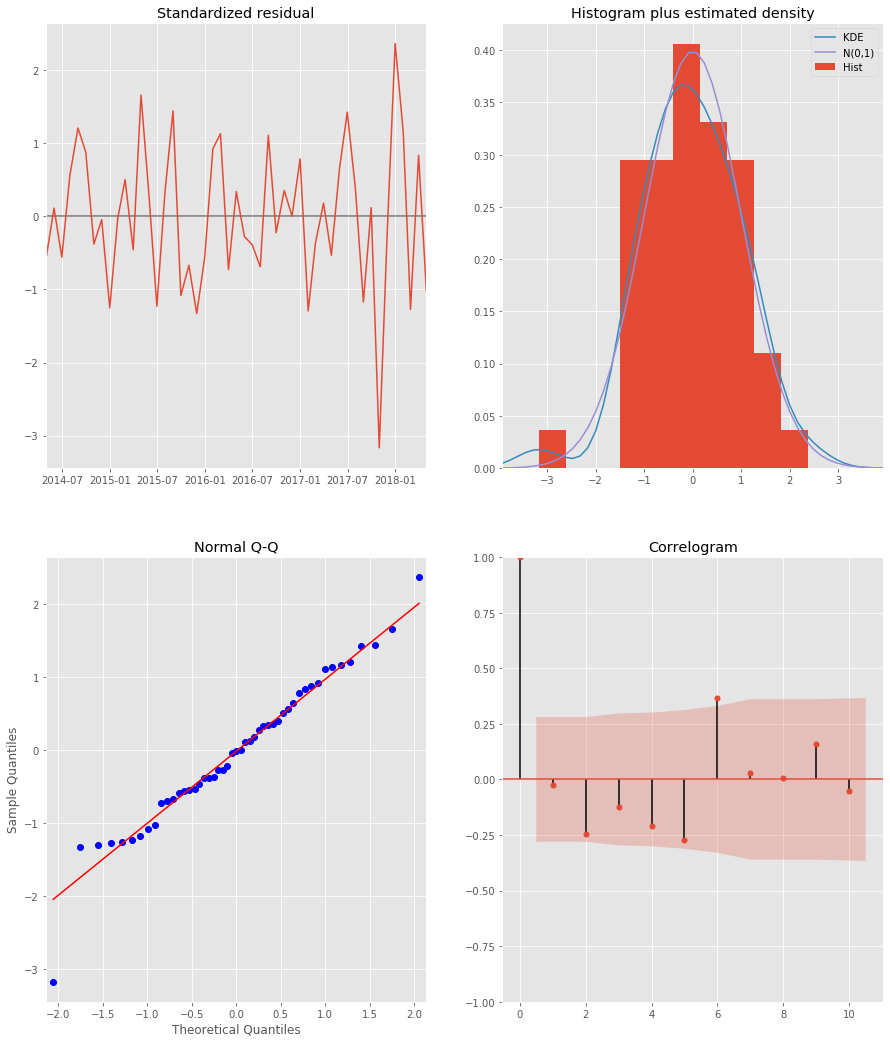

In [46]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [47]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

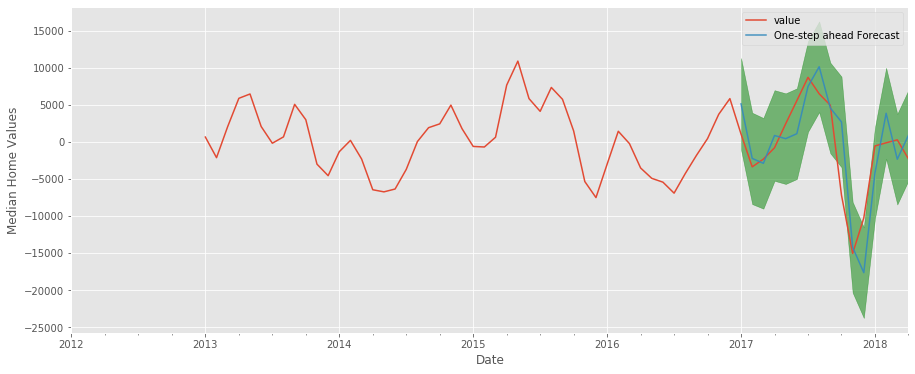

In [48]:

rcParams['figure.figsize'] = 15, 6

ax = two_two_zero['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [49]:
val_forecasted = pred.predicted_mean
val_truth = two_two_zero.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 16211500.76


### Model Validation - Dynamic Forecasting

In [50]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

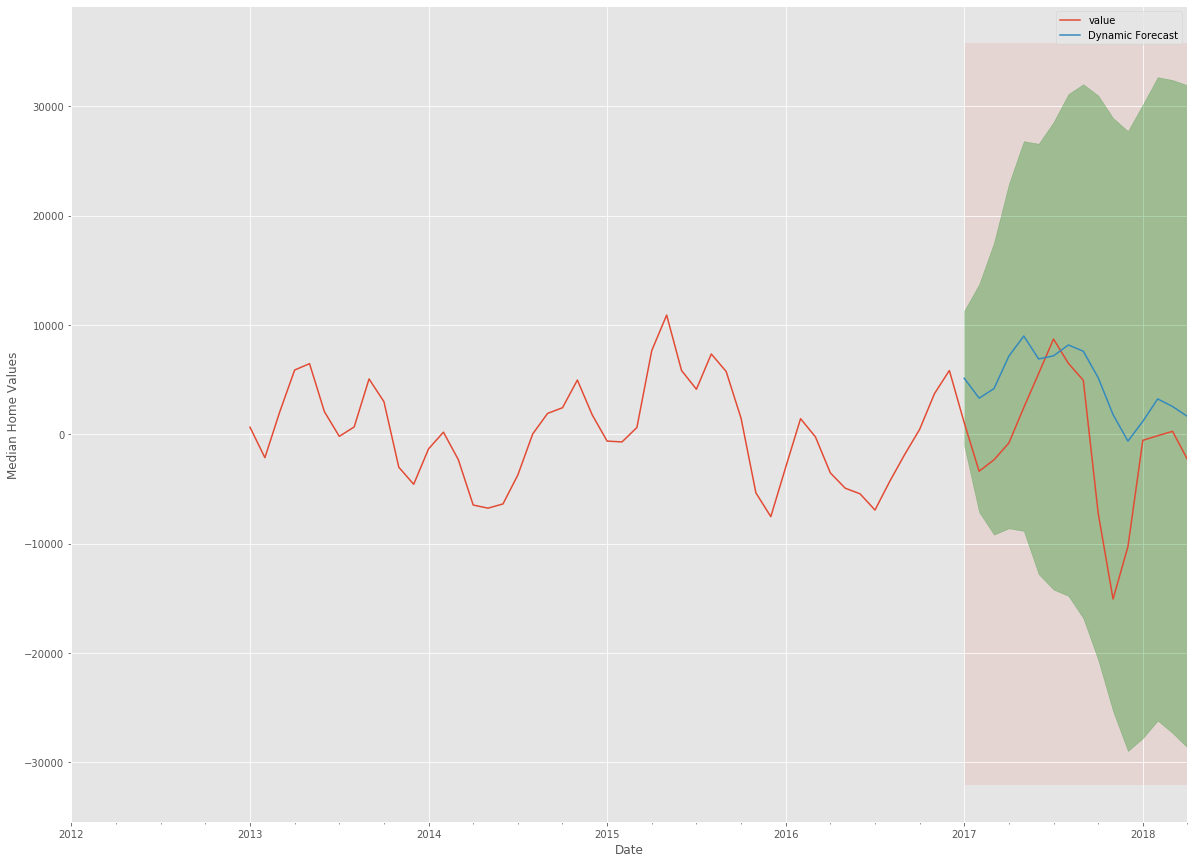

In [51]:
ax = two_two_zero['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [52]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_two_zero.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 49371849.26


### Visualizing Confidence Interval

In [53]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

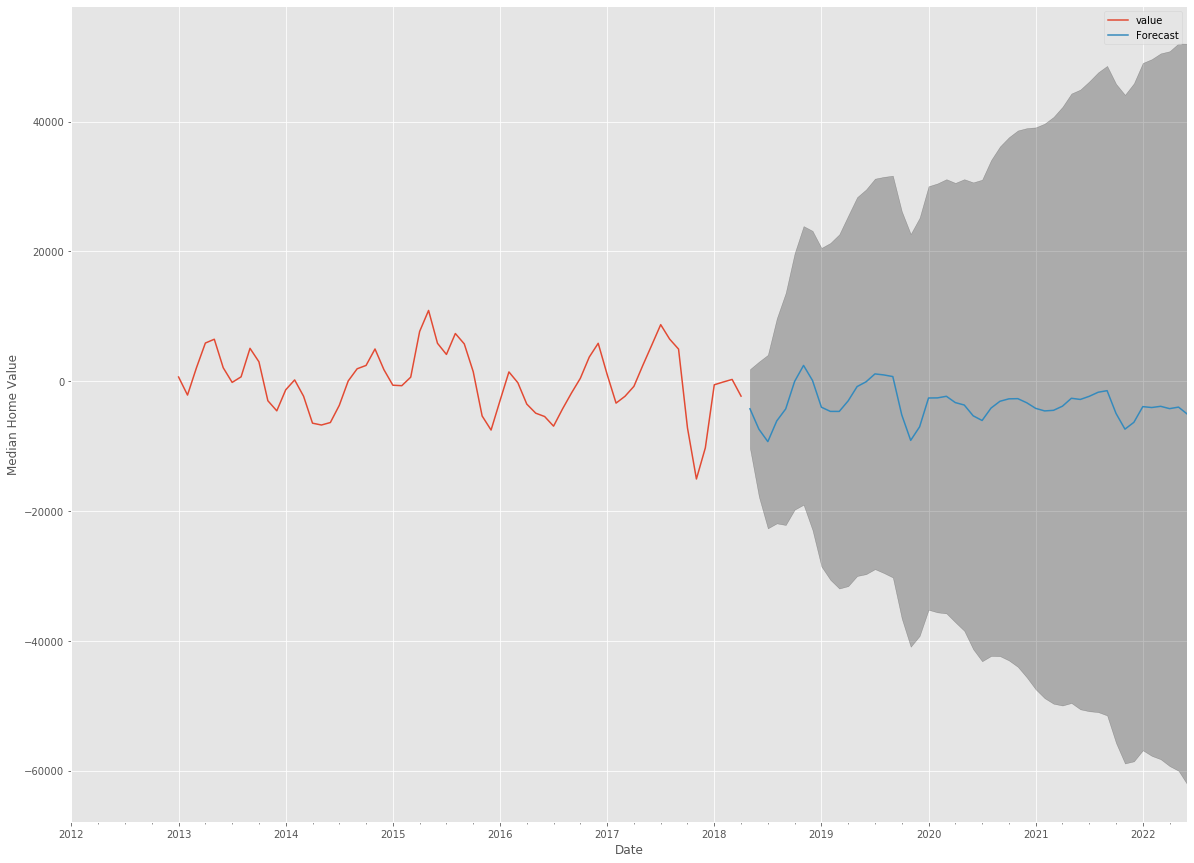

In [54]:
ax = two_two_zero.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11220 Conclusion: 

### 11216

In [55]:
two_one_six = kings_grouped.loc[11216]

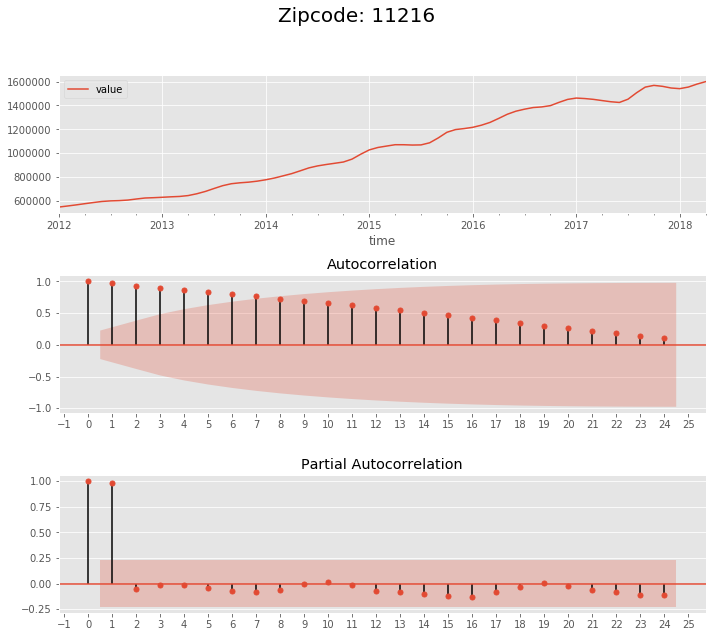

In [56]:
plot_acf_pacf(two_one_six, zipcode = '11216')
plt.show()

### Decompose Time Series

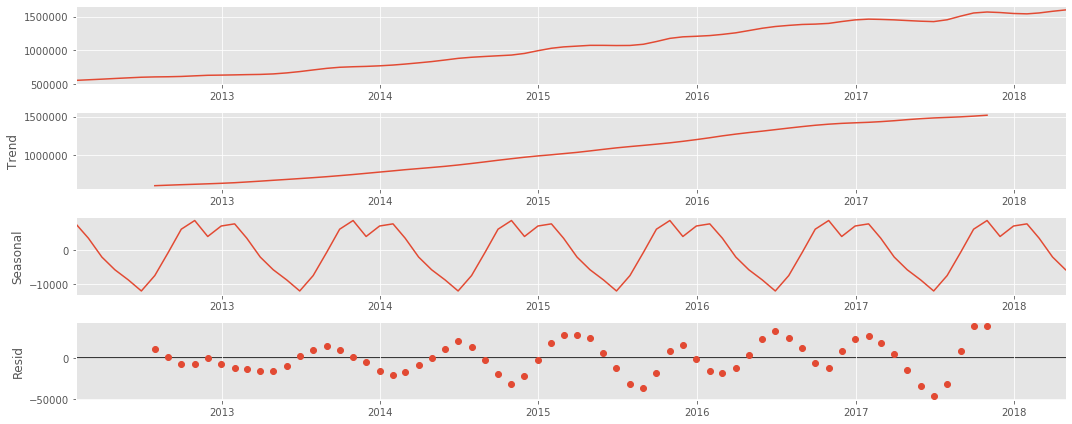

In [57]:
decompose_result = seasonal_decompose(two_one_six, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

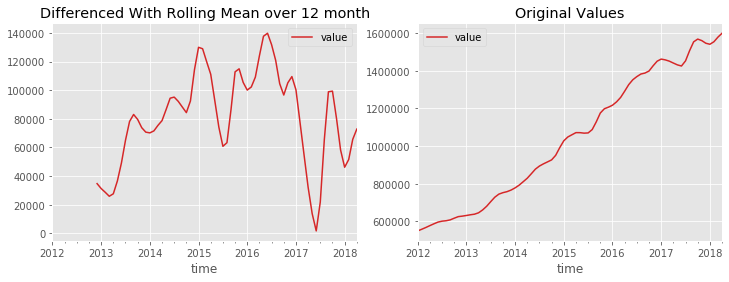

In [58]:
rolling_mean = two_one_six.rolling(window = 12).mean()
two_one_six_rolled_detrended = two_one_six - rolling_mean

ax1 = plt.subplot(121)
two_one_six_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_one_six.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [59]:
dftest = adfuller(two_one_six_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.2145639272929323
2. P-Value :  0.6672995106411237
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Using Differencing with Mean Rolled Time Series for Seasonality

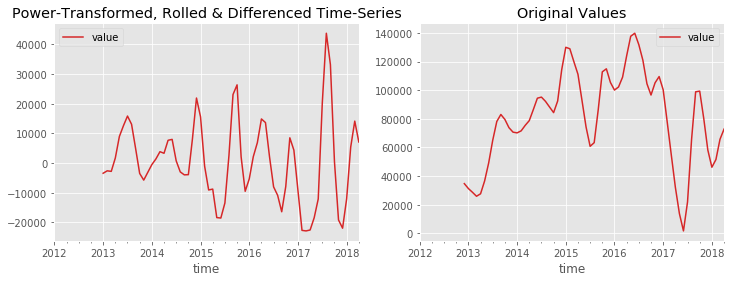

In [60]:
two_one_six_rolled_detrended_diff = two_one_six_rolled_detrended - two_one_six_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_one_six_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_one_six_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [61]:
two_one_six = two_one_six_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [62]:
dftest = adfuller(two_one_six.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.414231110611648
2. P-Value :  0.010483195695652878
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Parameter Selection

In [63]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [64]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_one_six, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [65]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1060.77
Name: 63, dtype: object

### Fitting the Time Series Model - ARIMA

In [66]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_one_six, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1358      0.942      0.144      0.885      -1.711       1.983
ma.L1          0.5784      0.567      1.020      0.308      -0.533       1.690
ar.S.L12      -0.5216      1.037     -0.503      0.615      -2.554       1.511
ma.S.L12      -1.0255      0.796     -1.288      0.198      -2.587       0.535
sigma2      2.406e+08   3.13e-09   7.68e+16      0.000    2.41e+08    2.41e+08


### Plot Diagnostics

1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

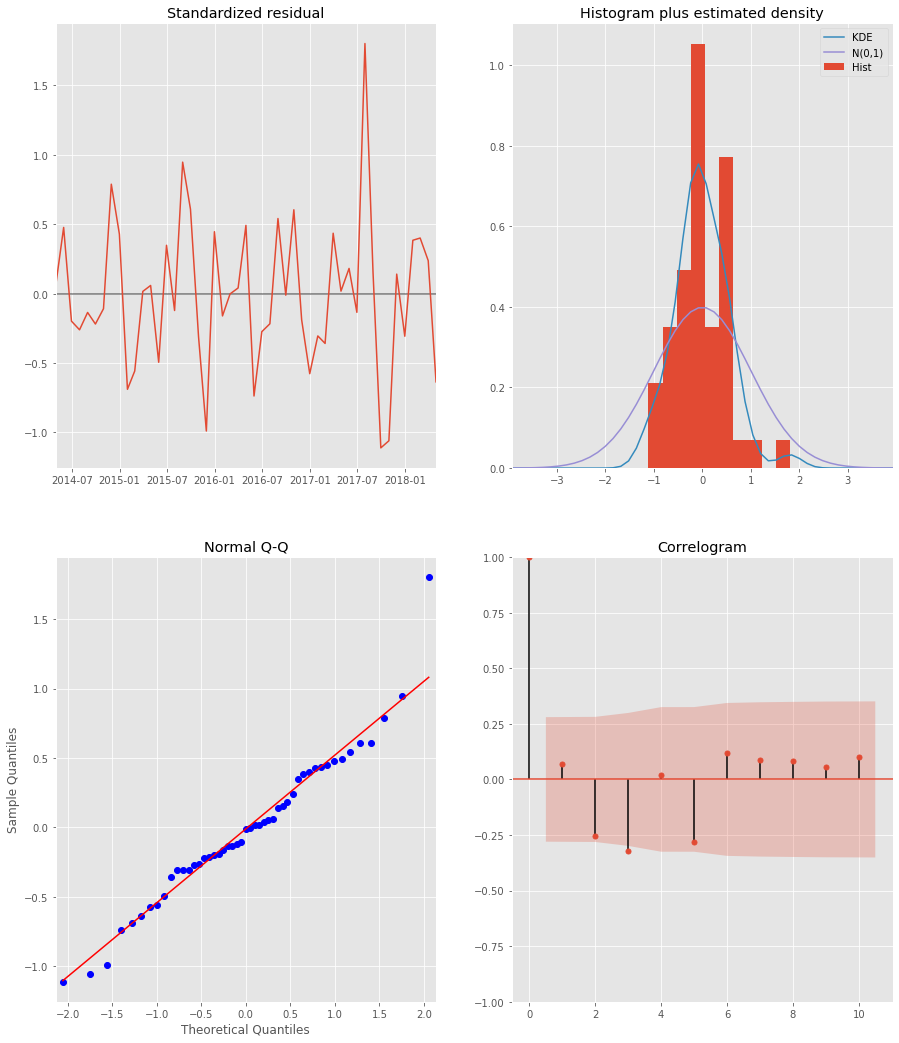

In [67]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [68]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

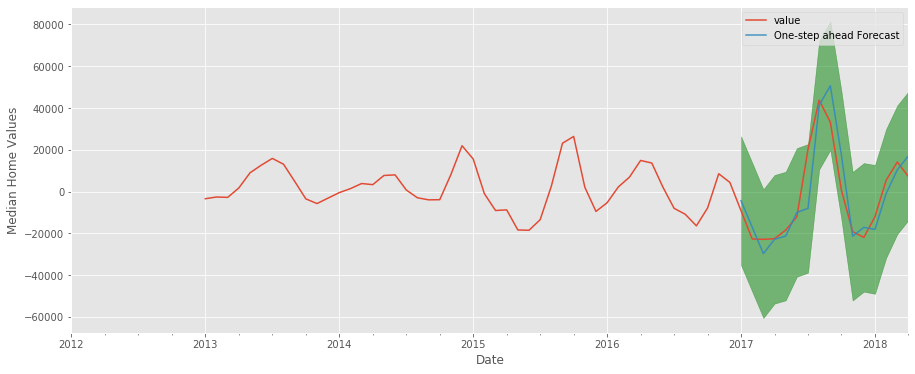

In [69]:

rcParams['figure.figsize'] = 15, 6

ax = two_one_six['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [70]:
val_forecasted = pred.predicted_mean
val_truth = two_one_six.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 107412355.46


### Model Validation - Dynamic Forecasting

In [71]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

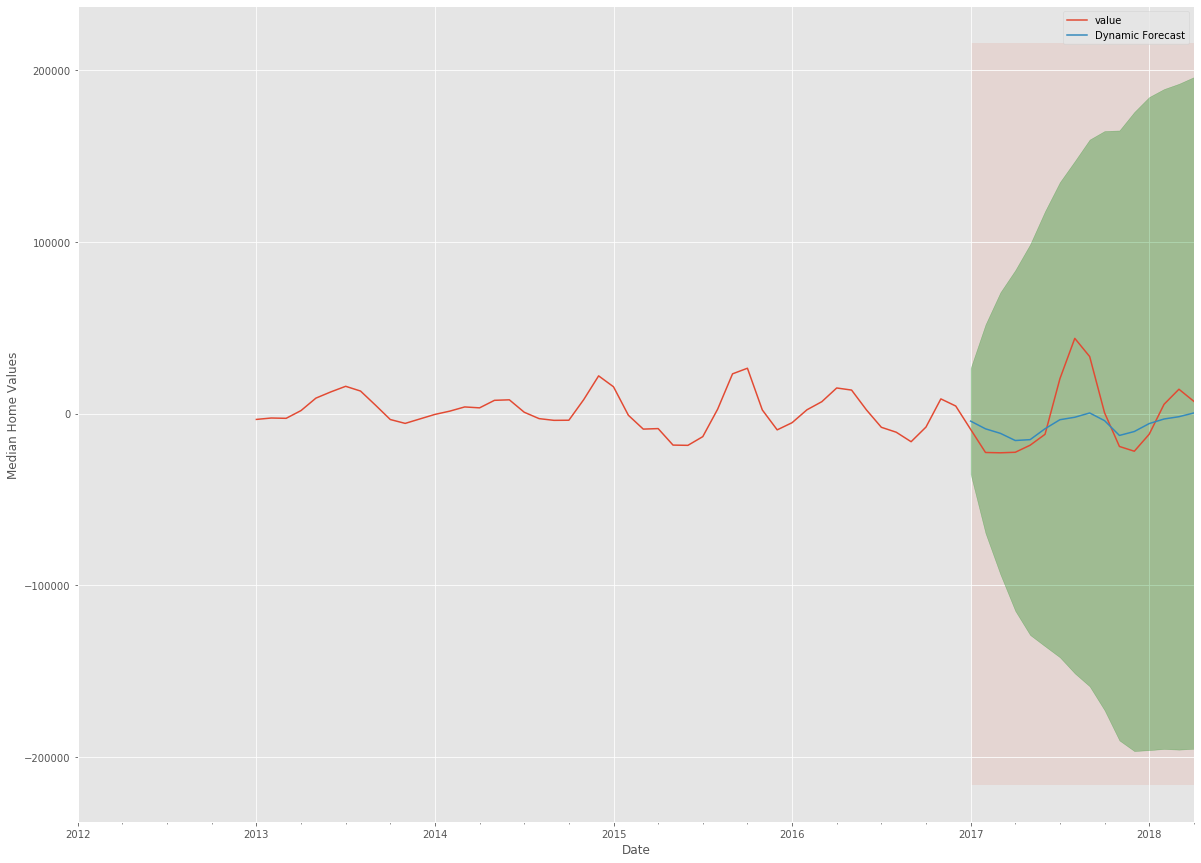

In [72]:
ax = two_one_six['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [73]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_one_six.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 298480885.77


### Visualizing Confidence Interval

In [74]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

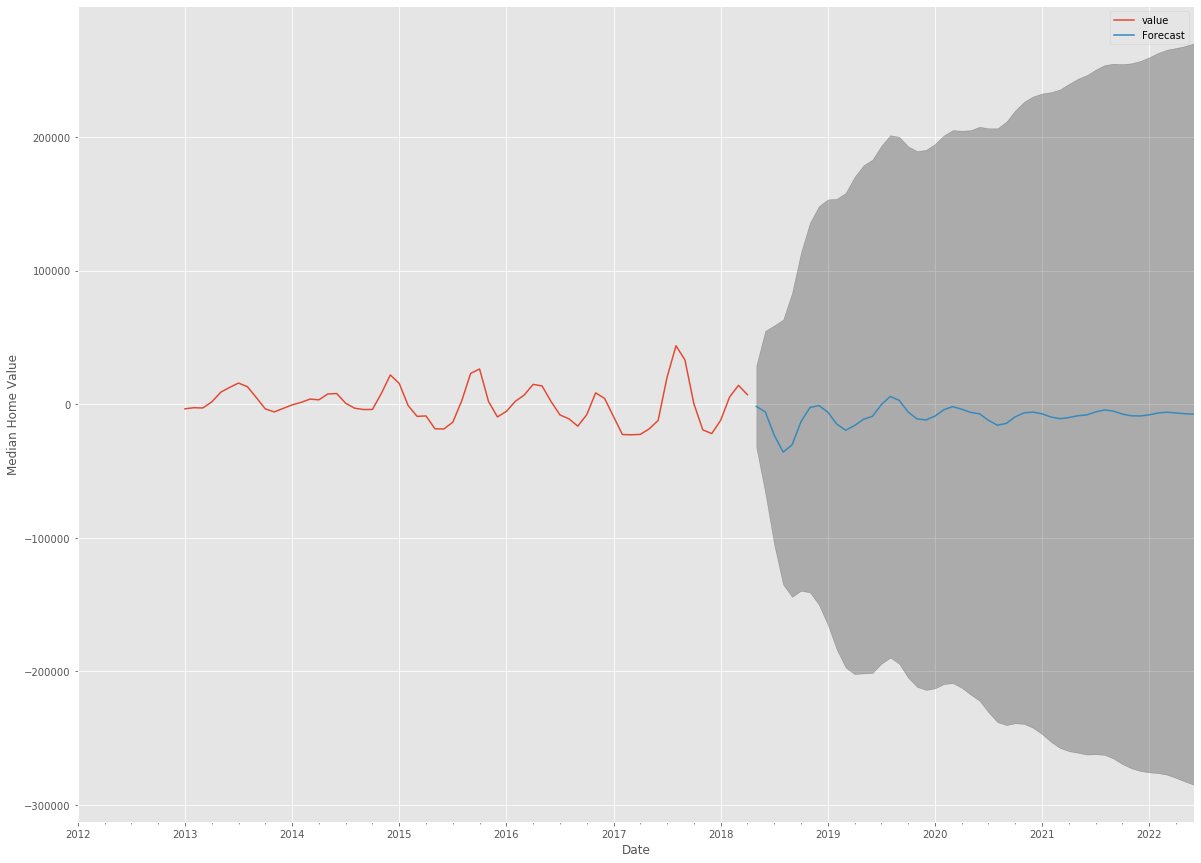

In [75]:
ax = two_one_six.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11216 Conclusion: 

### 11210

In [77]:
two_one_zero = kings_grouped.loc[11210]

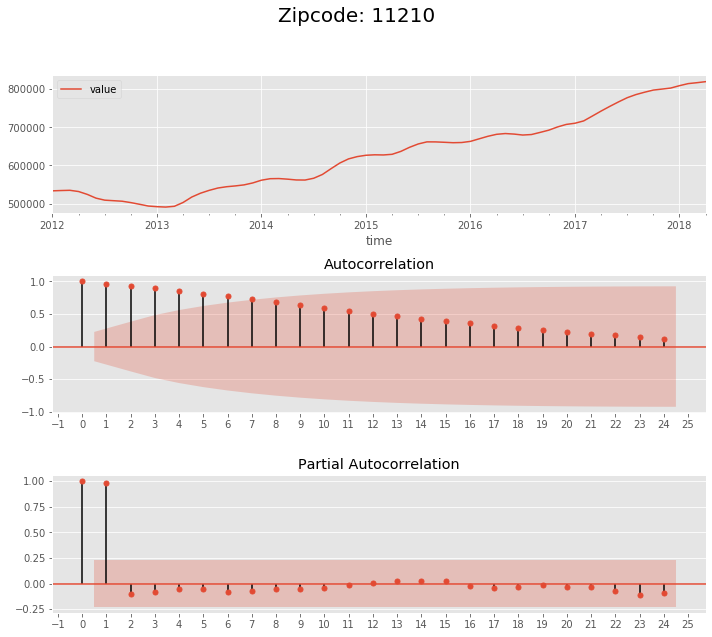

In [78]:
plot_acf_pacf(two_one_zero, zipcode = '11210')
plt.show()

### Decompose Time Series

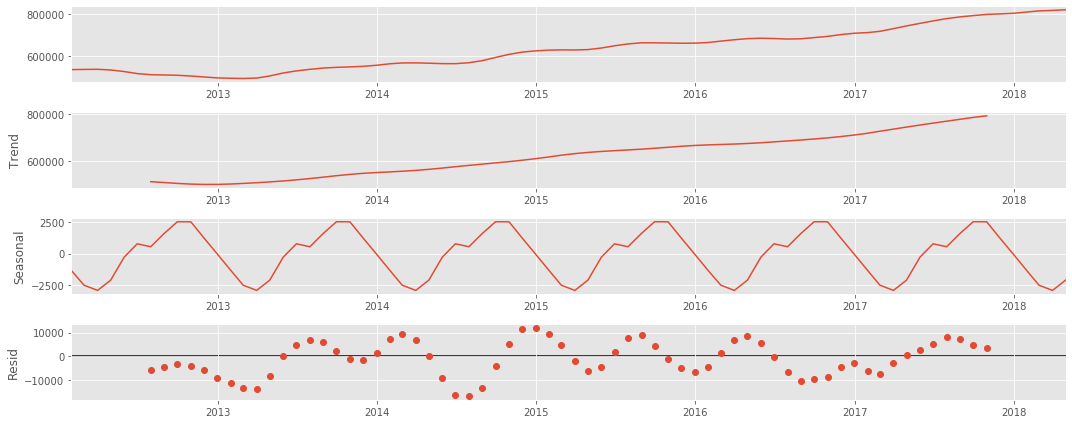

In [79]:
decompose_result = seasonal_decompose(two_one_zero, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

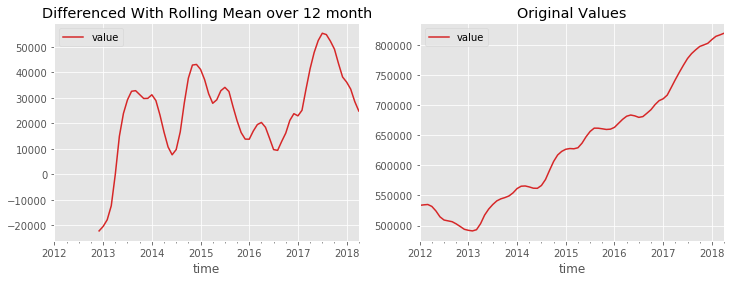

In [81]:
rolling_mean = two_one_zero.rolling(window = 12).mean()
two_one_zero_rolled_detrended = two_one_zero - rolling_mean

ax1 = plt.subplot(121)
two_one_zero_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_one_zero.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [82]:
dftest = adfuller(two_one_zero_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.3204867510865124
2. P-Value :  0.013987186049344581
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 58
5. Critical Values :
	 1% :  -3.548493559596539
	 5% :  -2.912836594776334
	 10% :  -2.594129155766944


### Using Differencing with Mean Rolled Time Series for Seasonality

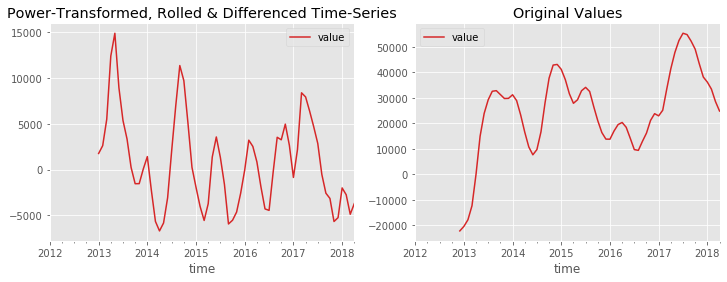

In [83]:
two_one_zero_rolled_detrended_diff = two_one_zero_rolled_detrended - two_one_zero_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_one_zero_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_one_zero_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [84]:
two_one_zero = two_one_zero_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [85]:
dftest = adfuller(two_one_zero.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.782737662445478
2. P-Value :  0.003088952369394891
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315


### Parameter Selection

In [86]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [87]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_one_zero, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [88]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           902.336
Name: 31, dtype: object

### Fitting the Time Series Model - ARIMA

In [89]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_one_zero, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6520      0.147      4.440      0.000       0.364       0.940
ar.S.L12      -0.4370      0.171     -2.562      0.010      -0.771      -0.103
ma.S.L12      -1.1371      0.206     -5.527      0.000      -1.540      -0.734
sigma2       3.76e+06   4.48e-08    8.4e+13      0.000    3.76e+06    3.76e+06


### Plot Diagnostics


1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

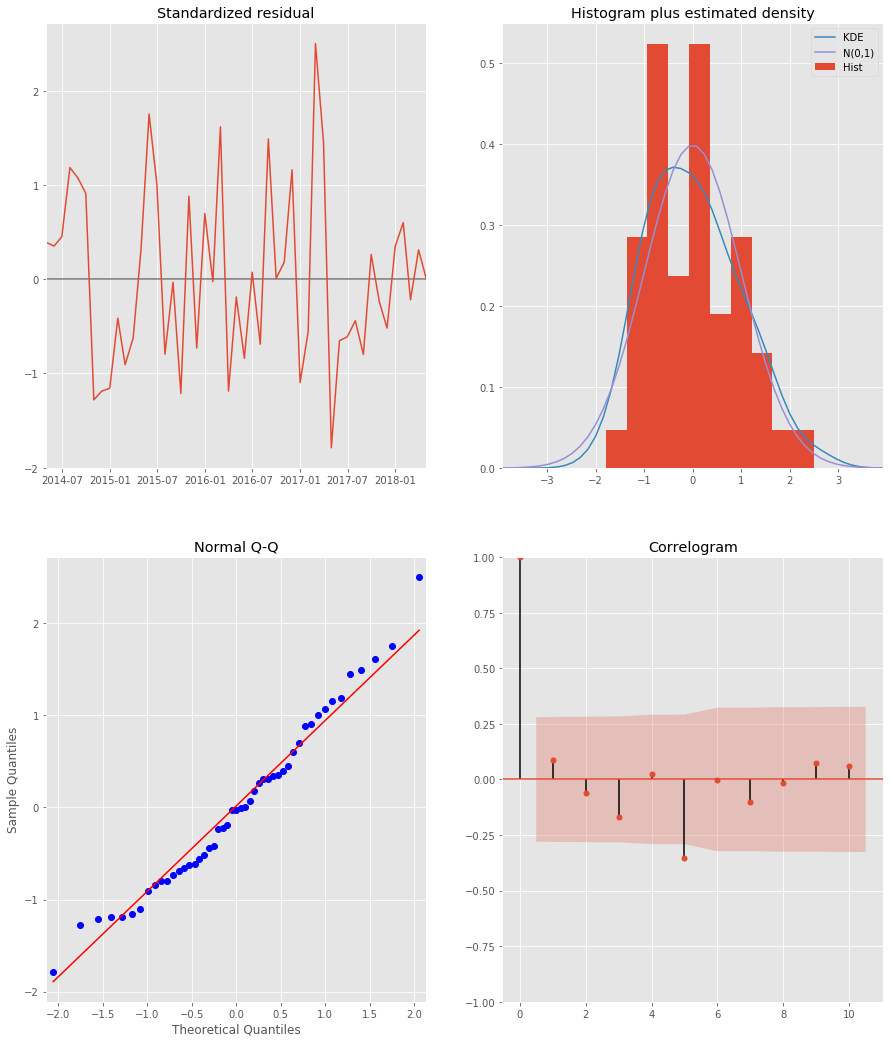

In [90]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [91]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

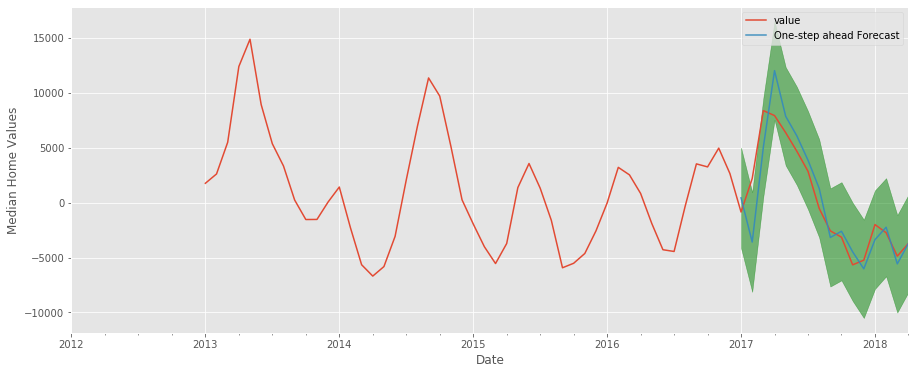

In [92]:

rcParams['figure.figsize'] = 15, 6

ax = two_one_zero['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [93]:
val_forecasted = pred.predicted_mean
val_truth = two_one_zero.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4790503.71


### Model Validation - Dynamic Forecasting

In [94]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

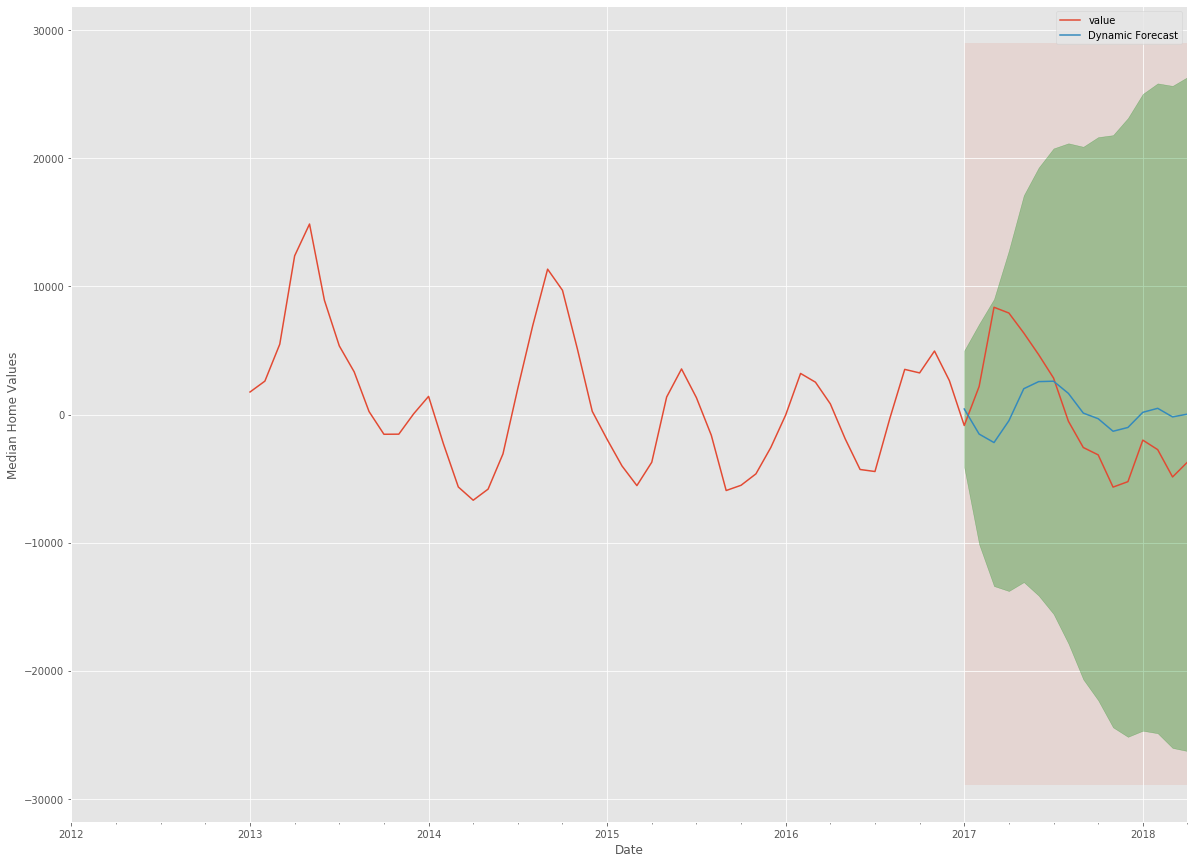

In [95]:
ax = two_one_zero['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [96]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_one_six.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 403533845.55


### Visualizing Confidence Interval

In [97]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

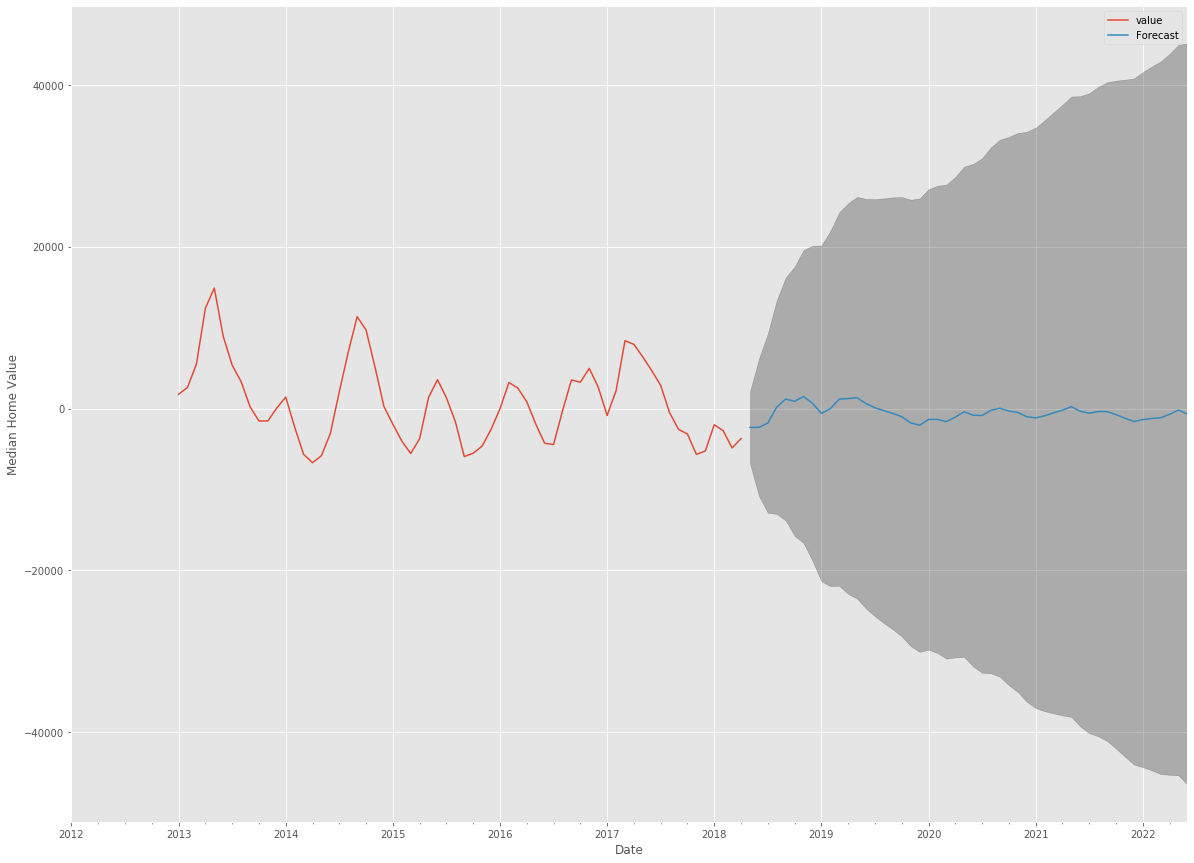

In [98]:
ax = two_one_zero.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11210 Conclusion: 

### 11224

In [99]:
two_two_four = kings_grouped.loc[11224]

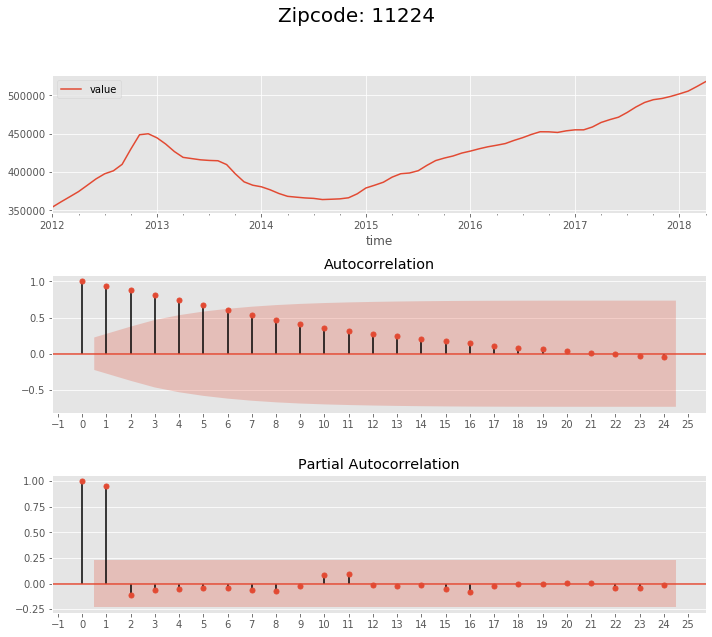

In [100]:
plot_acf_pacf(two_two_four, zipcode = '11224')
plt.show()

### Decompose Time Series

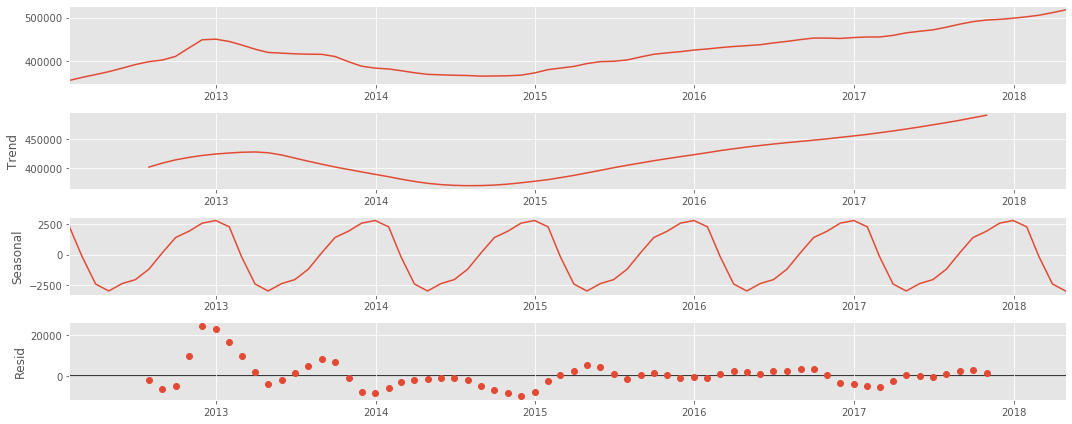

In [101]:
decompose_result = seasonal_decompose(two_two_four, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

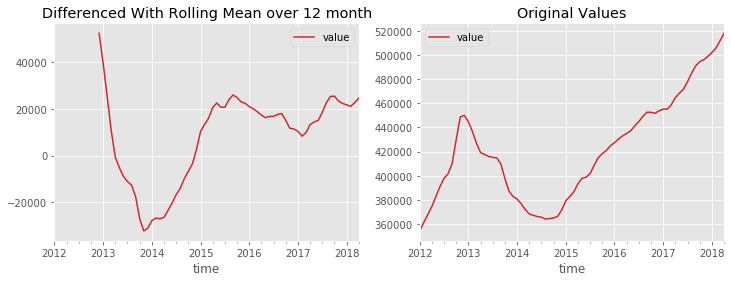

In [105]:
rolling_mean = two_two_four.rolling(window = 12).mean()
two_two_four_rolled_detrended = two_two_four - rolling_mean

ax1 = plt.subplot(121)
two_two_four_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_two_four.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [106]:
dftest = adfuller(two_two_four_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.075365485295352
2. P-Value :  0.028430785443930455
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 53
5. Critical Values :
	 1% :  -3.560242358792829
	 5% :  -2.9178502070837
	 10% :  -2.5967964150943397


### Using Differencing with Mean Rolled Time Series for Seasonality

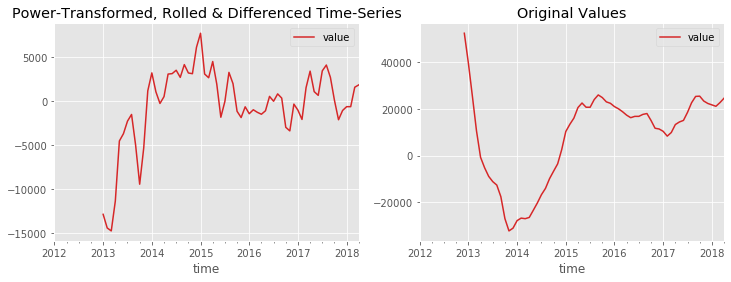

In [108]:
two_two_four_rolled_detrended_diff = two_two_four_rolled_detrended - two_two_four_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_two_four_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_two_four_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [109]:
two_two_four = two_two_four_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [110]:
dftest = adfuller(two_two_four.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.453203121117269
2. P-Value :  0.12727951181248498
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315


### Parameter Selection

In [111]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [112]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_two_four, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [113]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           876.822
Name: 59, dtype: object

### Fitting the Time Series Model - ARIMA

In [114]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_two_four, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3325      0.432     -0.770      0.441      -1.179       0.514
ma.L1          0.6335      0.349      1.816      0.069      -0.050       1.317
ma.S.L12      -1.3080      0.506     -2.585      0.010      -2.300      -0.316
sigma2      1.832e+06   1.06e+06      1.732      0.083   -2.42e+05    3.91e+06


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

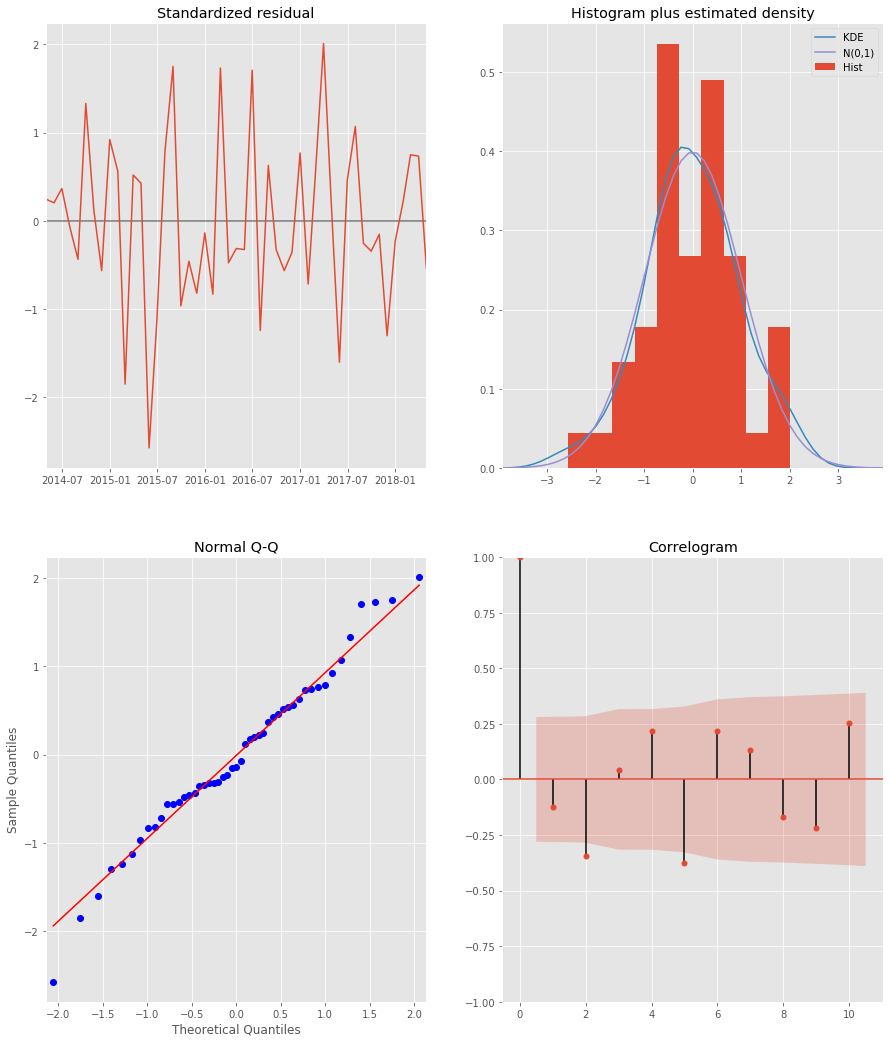

In [115]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [116]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

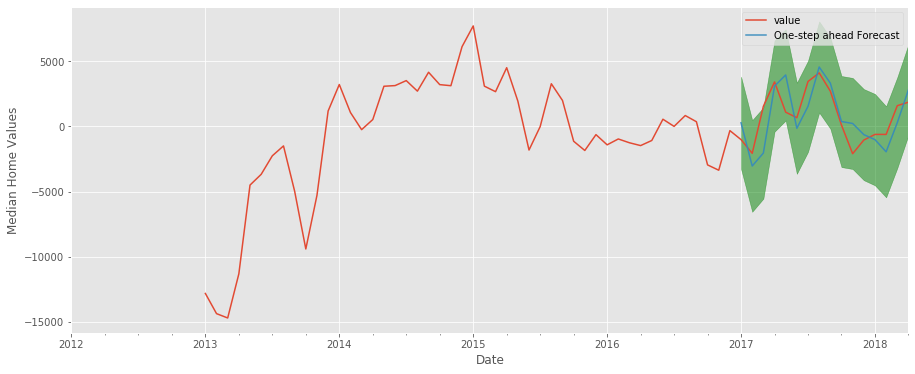

In [117]:

rcParams['figure.figsize'] = 15, 6

ax = two_two_four['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [118]:
val_forecasted = pred.predicted_mean
val_truth = two_two_four.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2430792.51


### Model Validation - Dynamic Forecasting

In [119]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

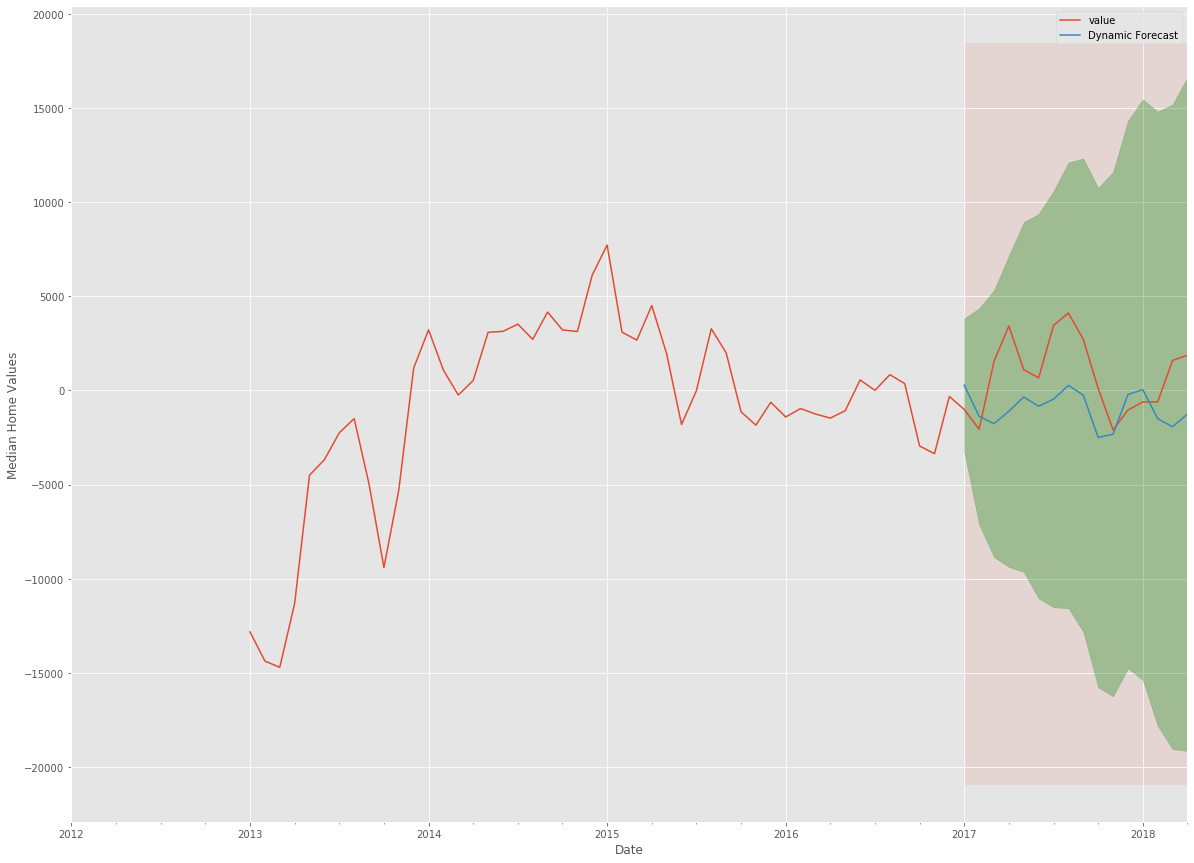

In [120]:
ax = two_two_four['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [121]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_two_four.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6740474.75


### Visualizing Confidence Interval

In [122]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

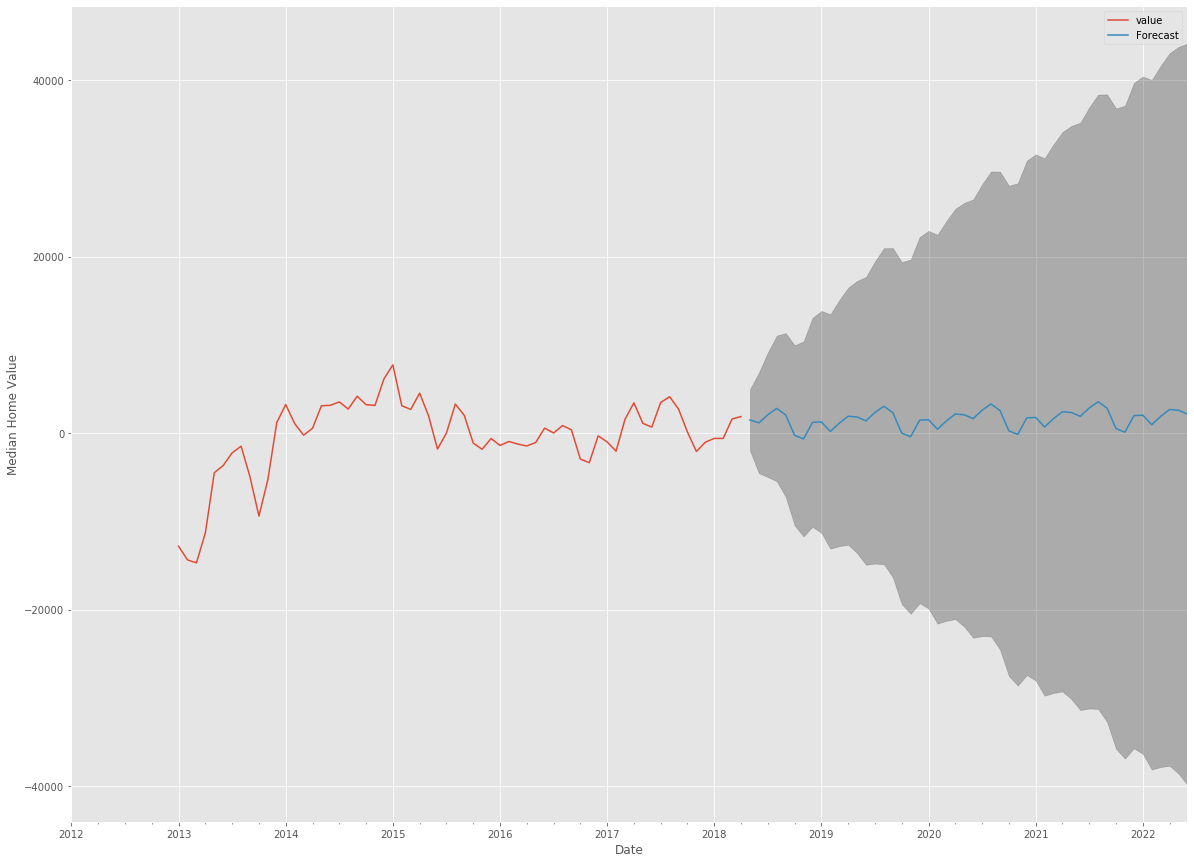

In [123]:
ax = two_two_four.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11224 Conclusion: 

### 11222

In [124]:
two_two_two = kings_grouped.loc[11222]

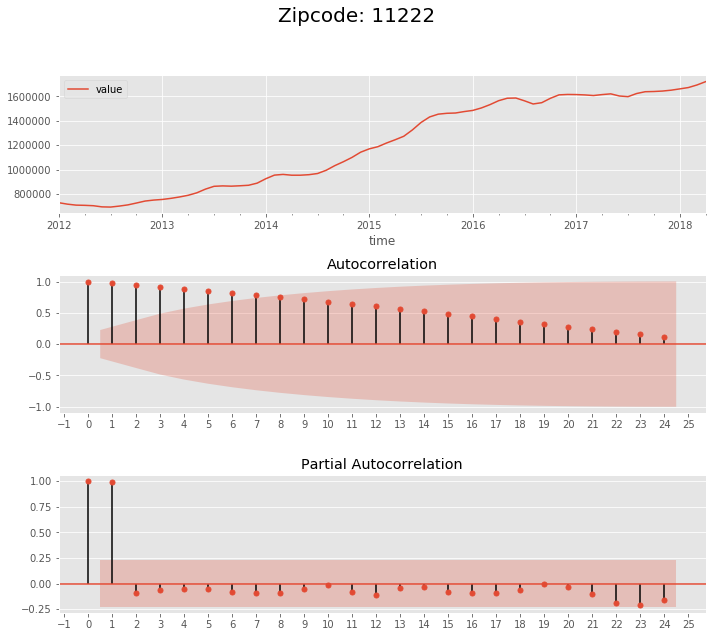

In [125]:
plot_acf_pacf(two_two_two, zipcode = '11222')
plt.show()

### Decompose Time Series

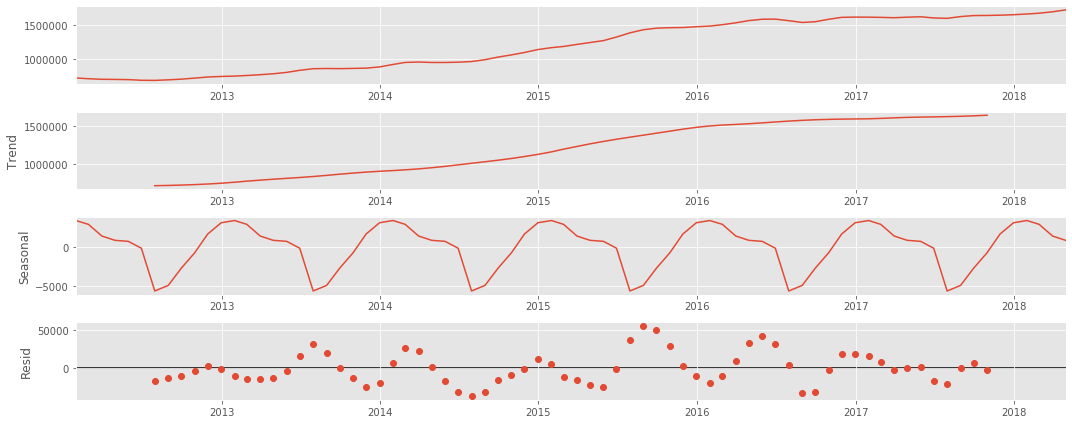

In [126]:
decompose_result = seasonal_decompose(two_two_two, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

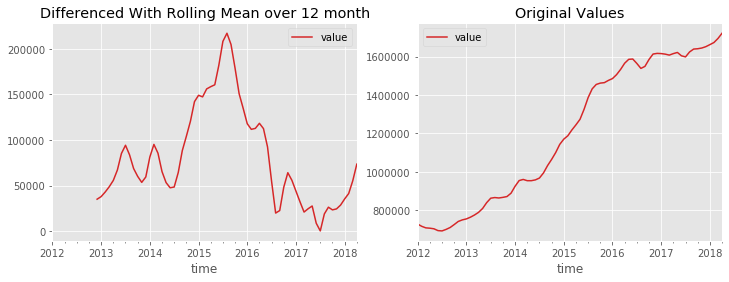

In [127]:
rolling_mean = two_two_two.rolling(window = 12).mean()
two_two_two_rolled_detrended = two_two_two - rolling_mean

ax1 = plt.subplot(121)
two_two_two_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_two_two.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [128]:
dftest = adfuller(two_two_two_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.9178948985891746
2. P-Value :  0.04330628713613458
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315


In [134]:
two_two_two = two_two_two_rolled_detrended.dropna()

### Parameter Selection

In [135]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [136]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_two_two, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [137]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           836.699
Name: 63, dtype: object

### Fitting the Time Series Model - ARIMA

In [138]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_two_two, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3887      0.372      1.044      0.296      -0.341       1.119
ma.L1          0.7113      0.244      2.918      0.004       0.234       1.189
ar.S.L12      -0.3997      0.510     -0.784      0.433      -1.399       0.600
ma.S.L12      -0.5153      0.507     -1.017      0.309      -1.508       0.478
sigma2      2.688e+08   1.64e-10   1.63e+18      0.000    2.69e+08    2.69e+08


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

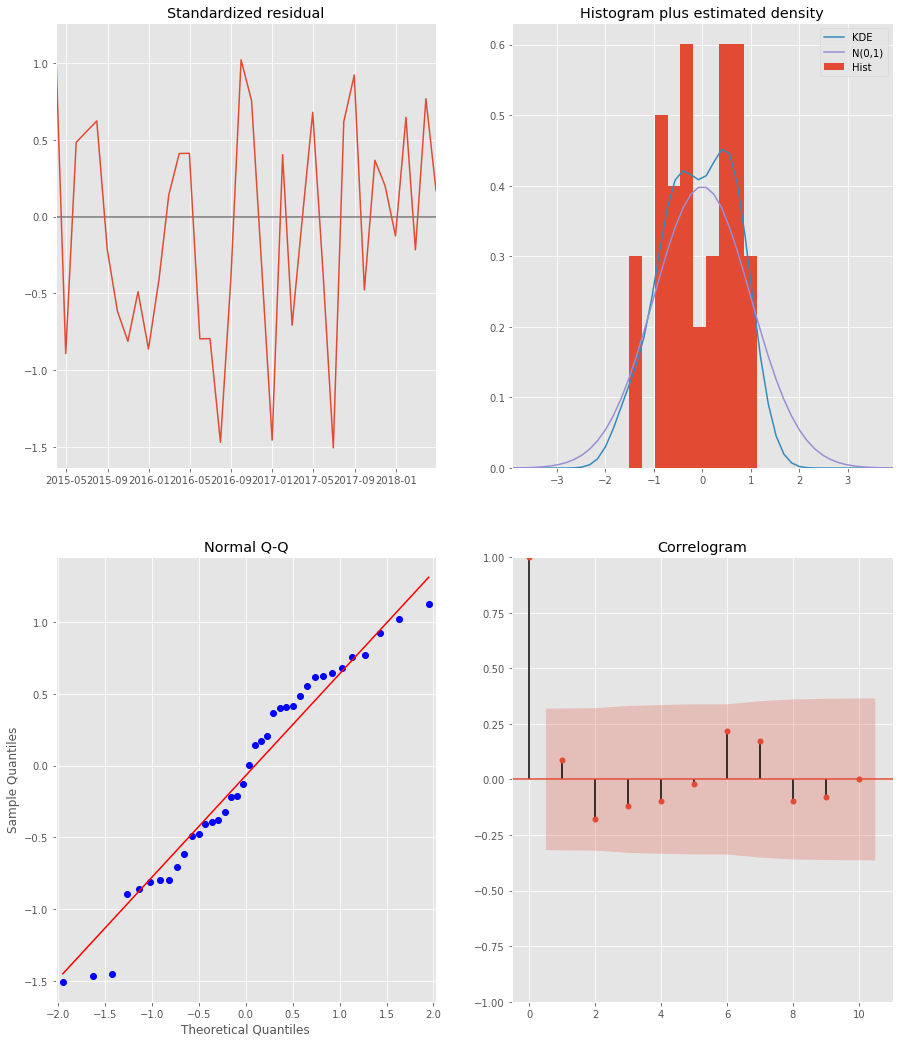

In [139]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [140]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

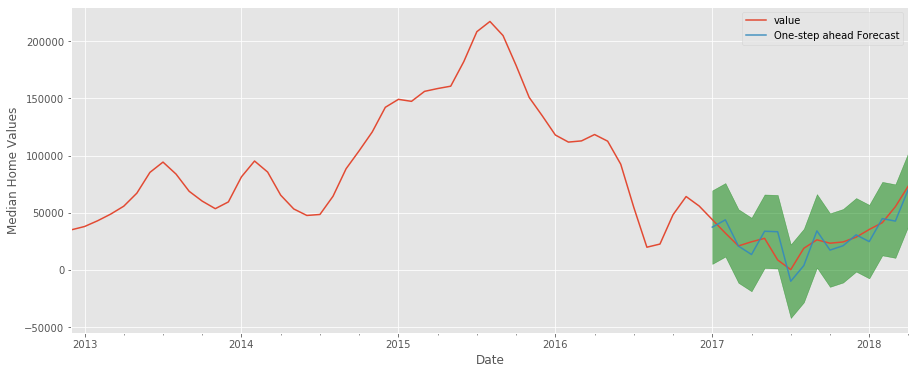

In [141]:

rcParams['figure.figsize'] = 15, 6

ax = two_two_two['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [142]:
val_forecasted = pred.predicted_mean
val_truth = two_two_two.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 105243788.15


### Model Validation - Dynamic Forecasting

In [143]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

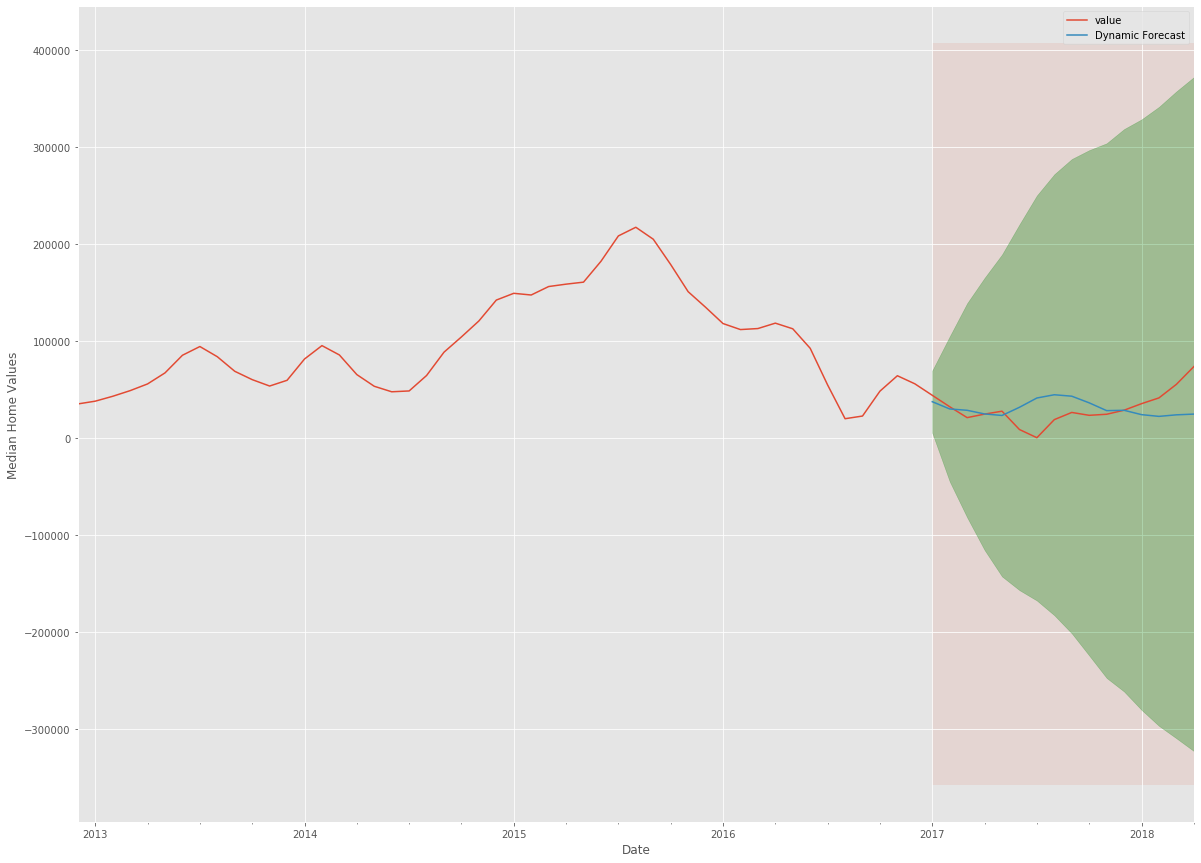

In [144]:
ax = two_two_two['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [145]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_two_two.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 457227582.28


### Visualizing Confidence Interval

In [146]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

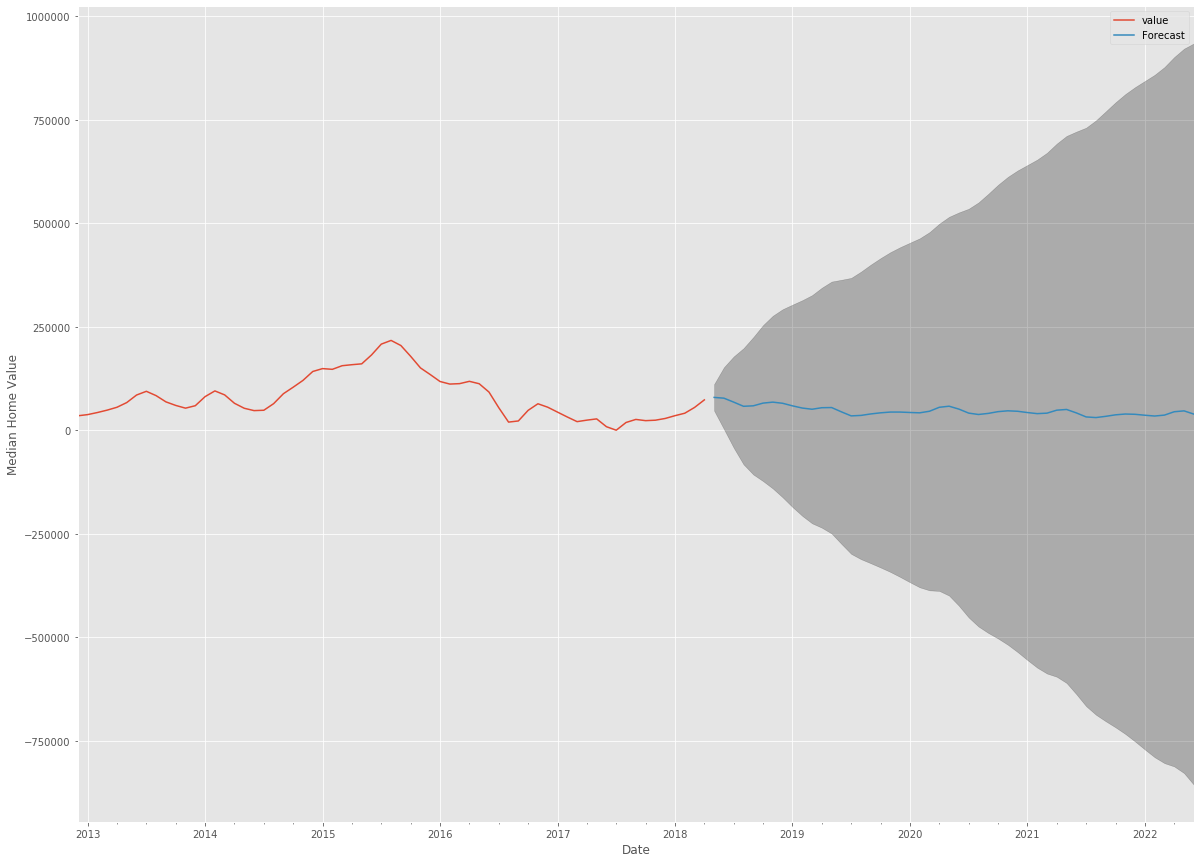

In [147]:
ax = two_two_two.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11222 Conclusion: 

### 11205

In [148]:
two_zero_five = kings_grouped.loc[11205]

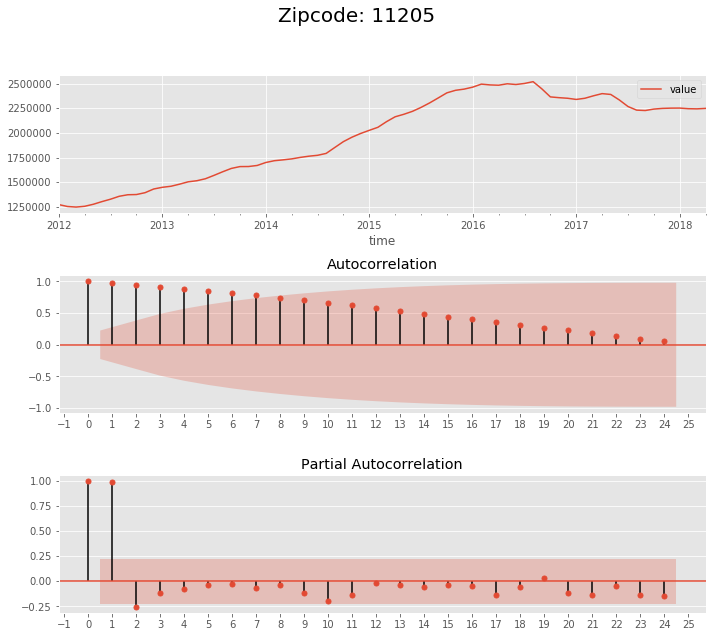

In [149]:
plot_acf_pacf(two_zero_five, zipcode = '11205')
plt.show()

### Decompose Time Series

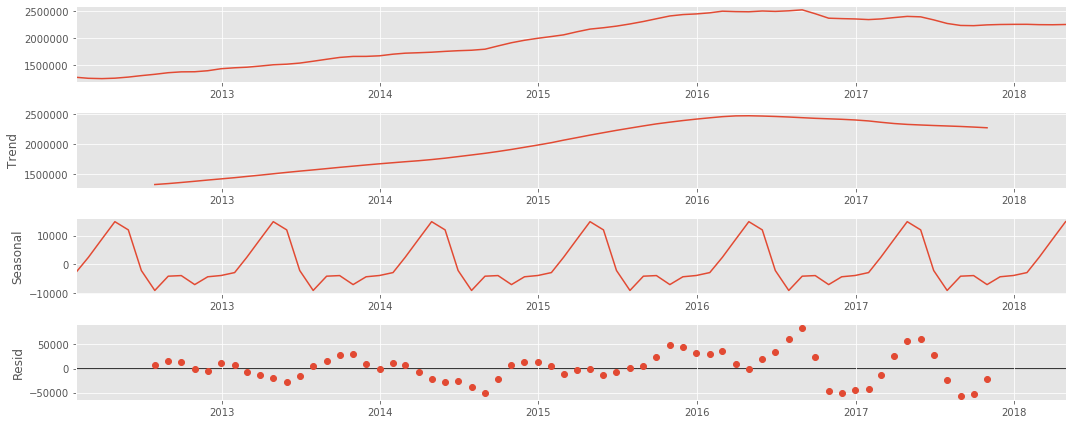

In [150]:
decompose_result = seasonal_decompose(two_zero_five, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

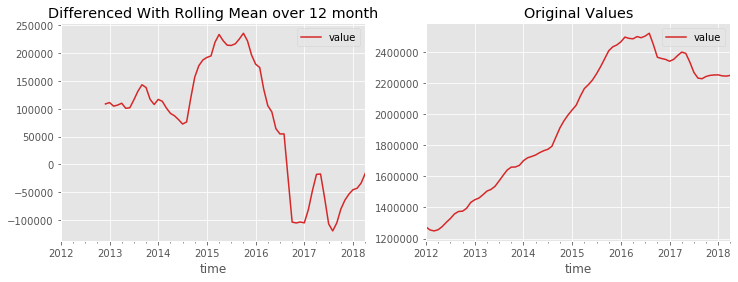

In [151]:
rolling_mean = two_zero_five.rolling(window = 12).mean()
two_zero_five_rolled_detrended = two_zero_five - rolling_mean

ax1 = plt.subplot(121)
two_zero_five_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_zero_five.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [152]:
dftest = adfuller(two_zero_five_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.0713086873448385
2. P-Value :  0.256206889114118
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 56
5. Critical Values :
	 1% :  -3.552928203580539
	 5% :  -2.9147306250000002
	 10% :  -2.595137155612245


### Using Differencing with Mean Rolled Time Series for Seasonality

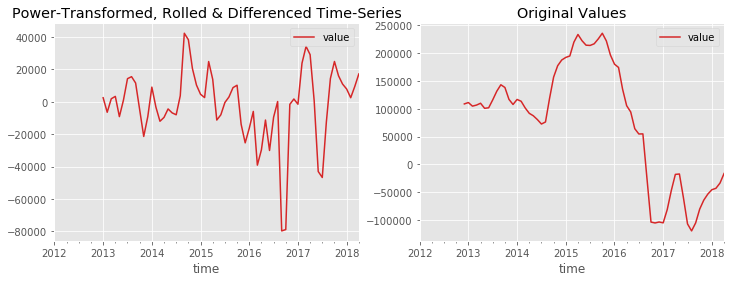

In [153]:
two_zero_five_rolled_detrended_diff = two_zero_five_rolled_detrended - two_zero_five_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_zero_five_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_zero_five_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [154]:
two_zero_five = two_zero_five_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [155]:
dftest = adfuller(two_zero_five.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.346889694361334
2. P-Value :  0.15729055283387594
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


### Parameter Selection

In [156]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [157]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_zero_five, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [158]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1137.32
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

In [160]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_zero_five, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7141      0.229      3.115      0.002       0.265       1.163
ma.S.L12      -1.0835      0.309     -3.510      0.000      -1.689      -0.478
sigma2      1.187e+09   1.61e-10   7.35e+18      0.000    1.19e+09    1.19e+09


### Plot Diagnostics


1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

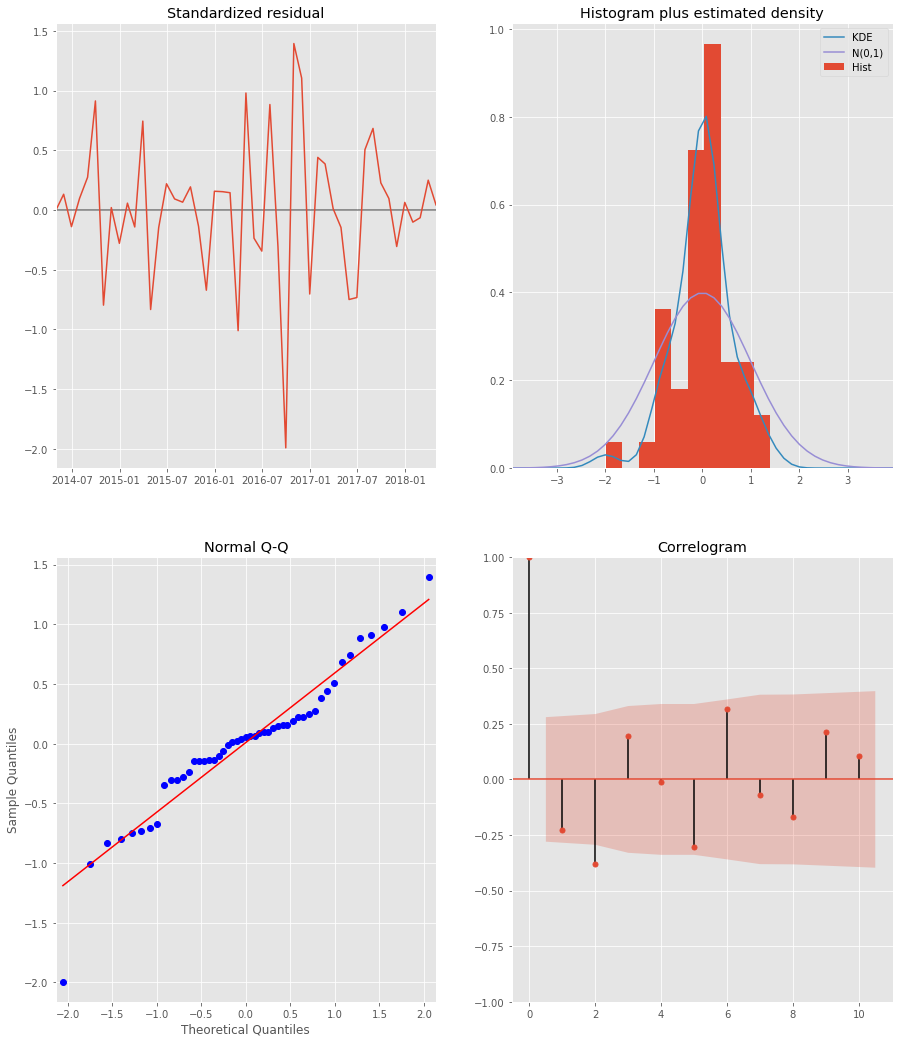

In [161]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [162]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

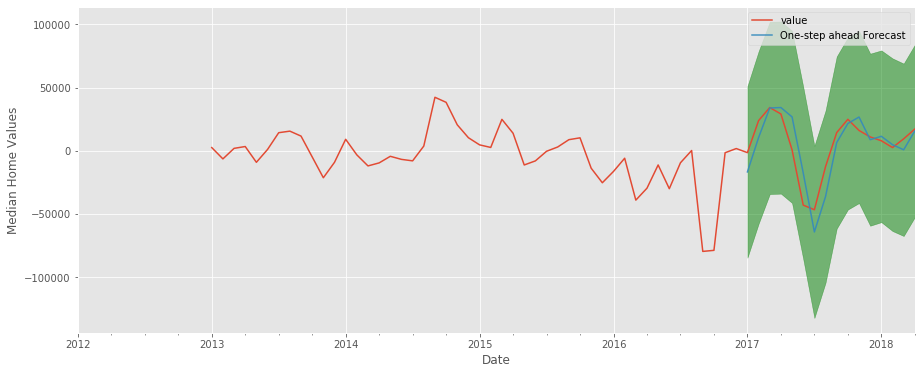

In [163]:

rcParams['figure.figsize'] = 15, 6

ax = two_zero_five['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [164]:
val_forecasted = pred.predicted_mean
val_truth = two_zero_five.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 182893894.02


### Model Validation - Dynamic Forecasting

In [165]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

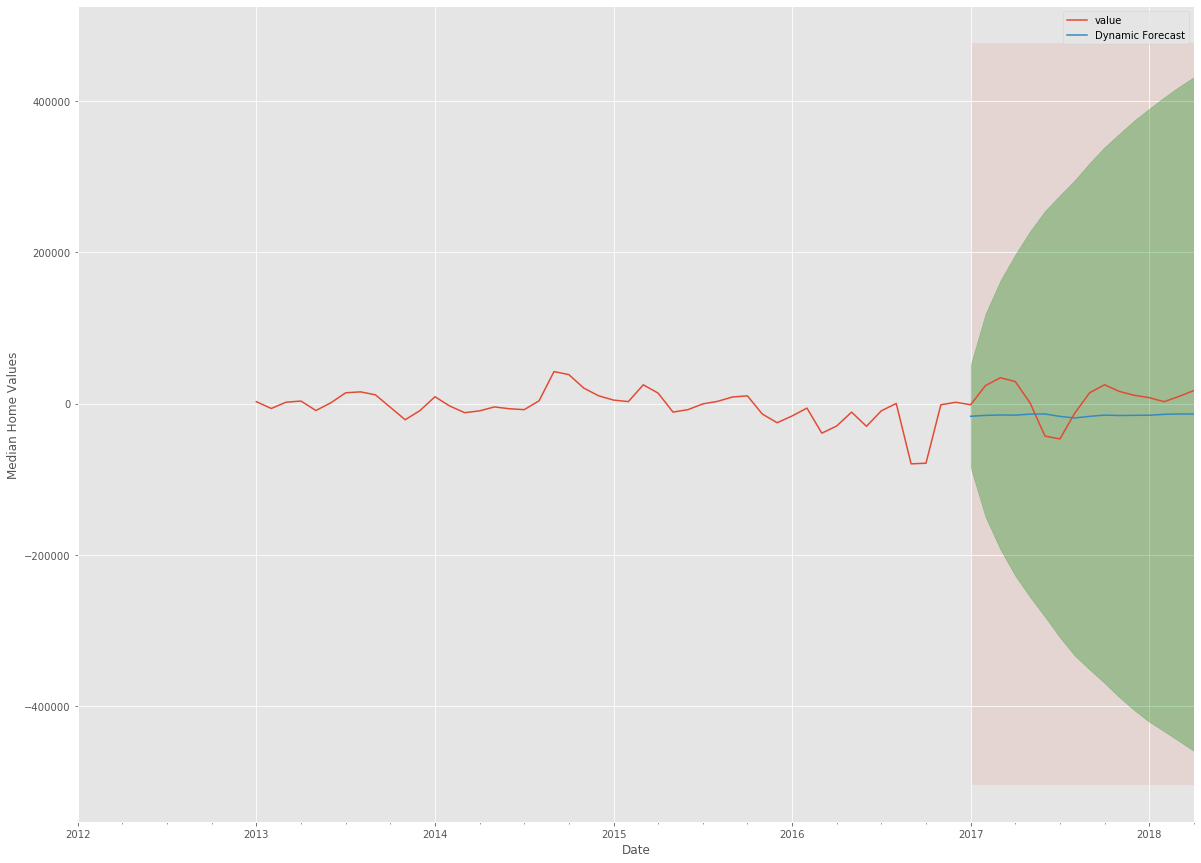

In [166]:
ax = two_zero_five['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [167]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_zero_five.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 925573675.5


### Visualizing Confidence Interval

In [168]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

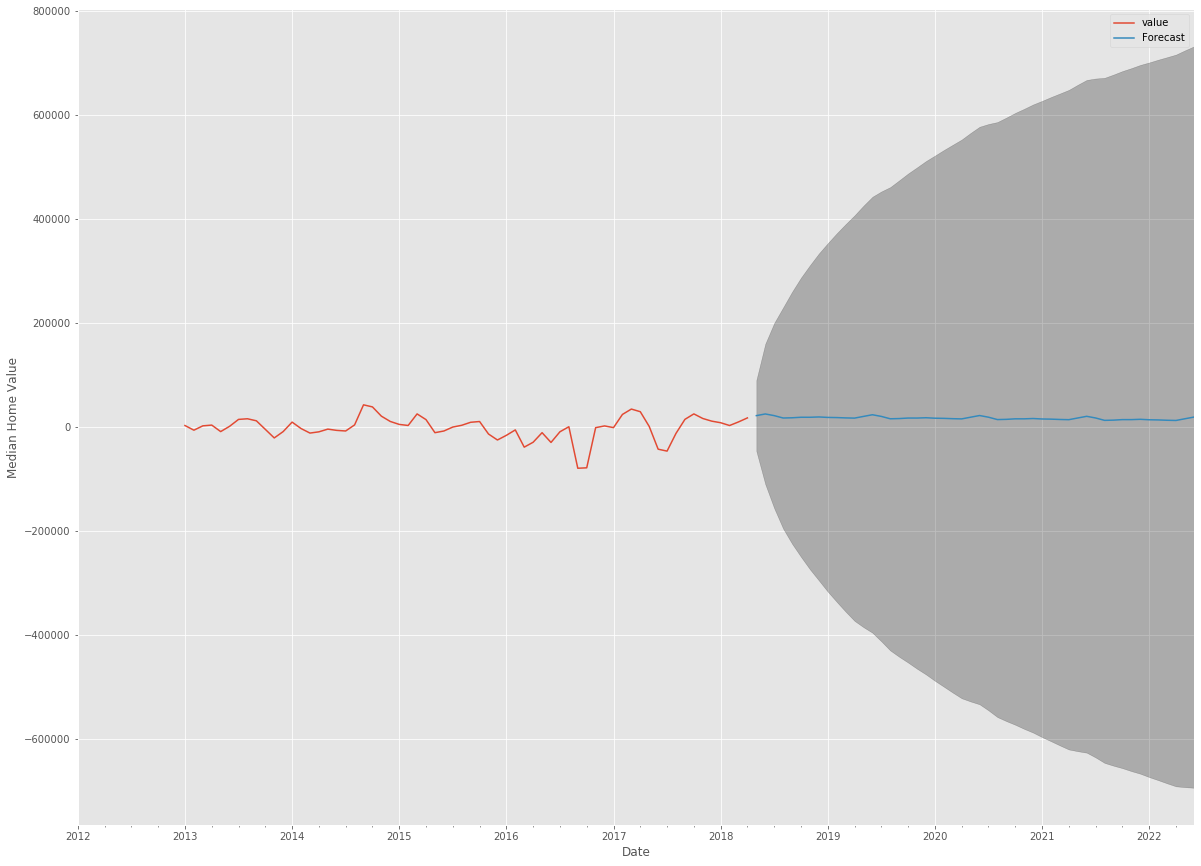

In [169]:
ax = two_zero_five.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11205 Conclusion: 

### 11217

In [170]:
two_one_seven = kings_grouped.loc[11217]

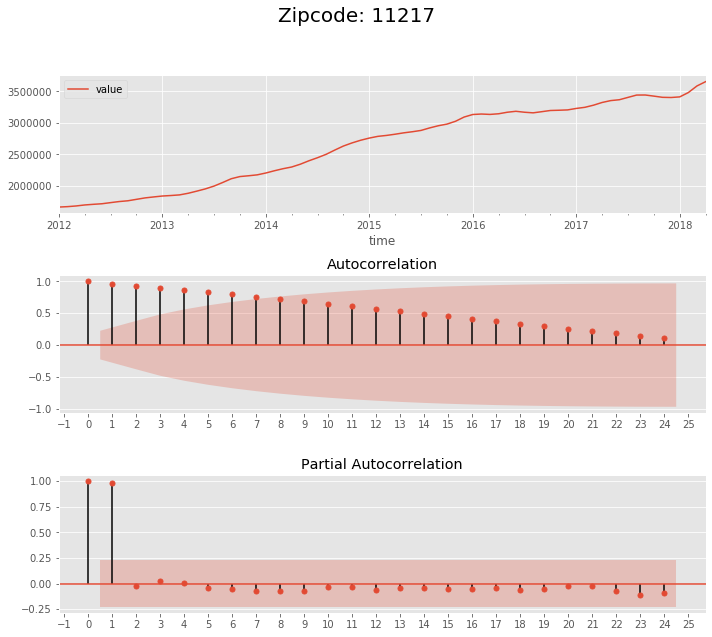

In [171]:
plot_acf_pacf(two_one_seven, zipcode = '11217')
plt.show()

### Decompose Time Series

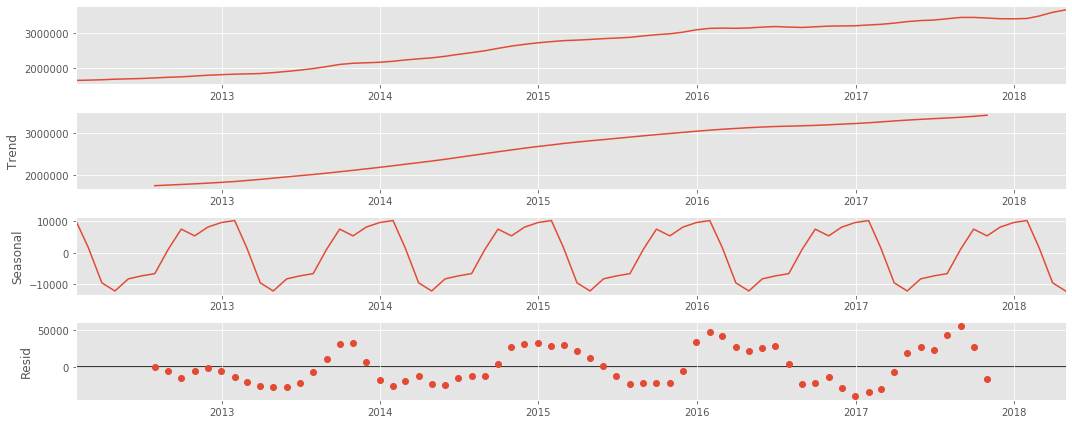

In [172]:
decompose_result = seasonal_decompose(two_one_seven, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

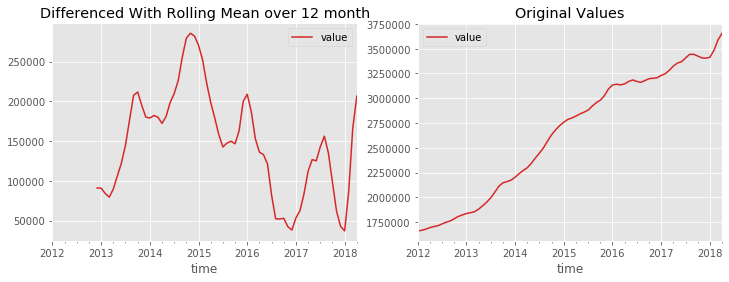

In [174]:
rolling_mean = two_one_seven.rolling(window = 12).mean()
two_one_seven_rolled_detrended = two_one_seven - rolling_mean

ax1 = plt.subplot(121)
two_one_seven_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_one_seven.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [175]:
dftest = adfuller(two_one_seven_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.829370185368405
2. P-Value :  0.3659807545744432
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776


### Using Differencing with Mean Rolled Time Series for Seasonality

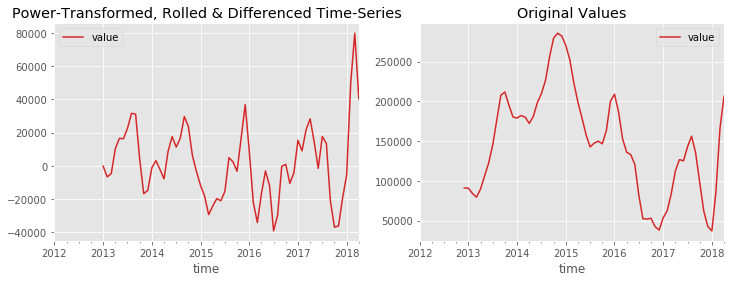

In [176]:
two_one_seven_rolled_detrended_diff = two_one_seven_rolled_detrended - two_one_seven_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_one_seven_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_one_seven_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [178]:
two_one_seven = two_one_seven_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [179]:
dftest = adfuller(two_one_seven.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.045246141475175
2. P-Value :  0.0011912669761019732
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 57
5. Critical Values :
	 1% :  -3.5506699942762414
	 5% :  -2.913766394626147
	 10% :  -2.5946240473991997


### Parameter Selection

In [180]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [181]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_one_seven, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [182]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1103.35
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

In [183]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_one_seven, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6633      0.258      2.576      0.010       0.159       1.168
ma.S.L12      -1.0785      0.212     -5.088      0.000      -1.494      -0.663
sigma2       5.36e+08   1.82e-10   2.94e+18      0.000    5.36e+08    5.36e+08


### Plot Diagnostics

1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

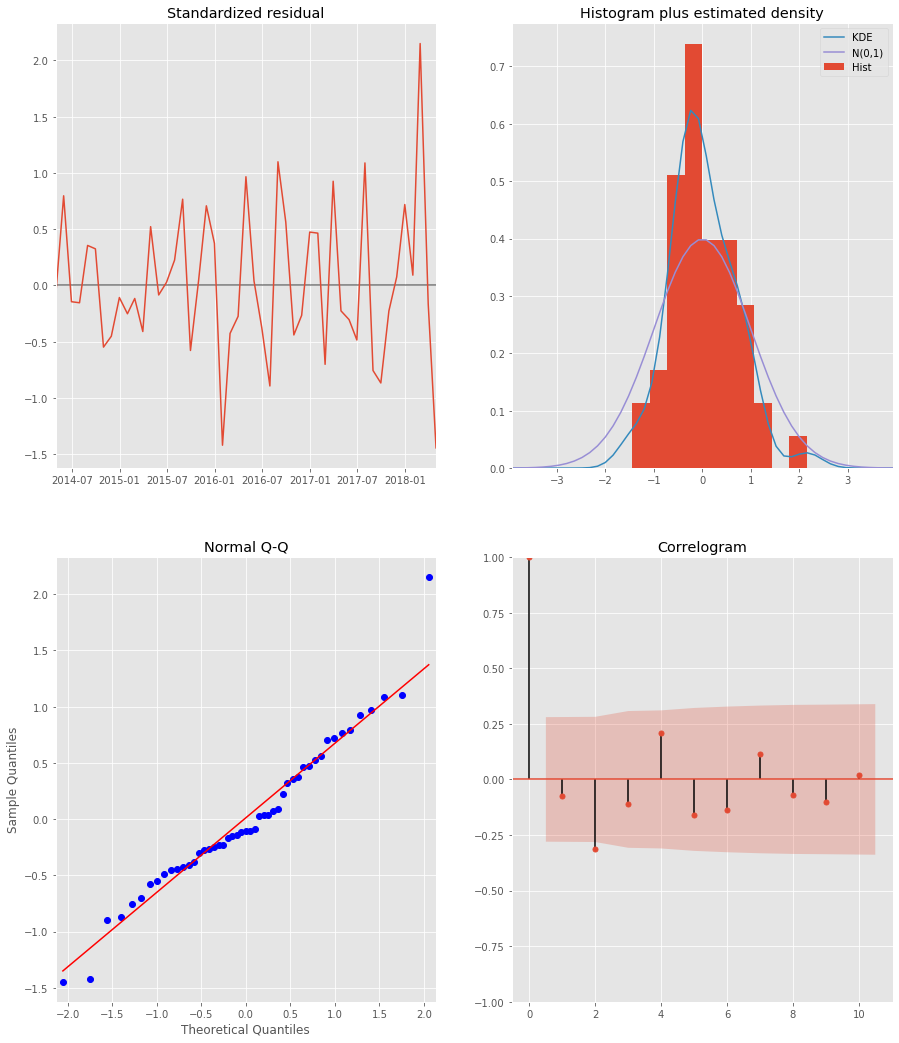

In [184]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [185]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

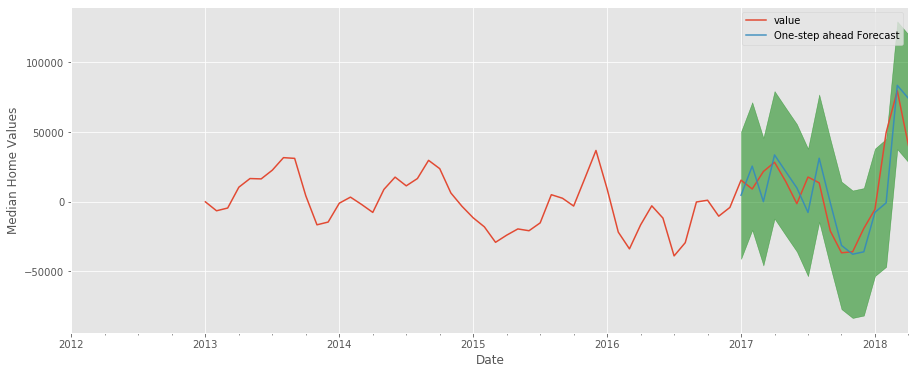

In [186]:

rcParams['figure.figsize'] = 15, 6

ax = two_one_seven['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [187]:
val_forecasted = pred.predicted_mean
val_truth = two_one_seven.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 404118679.43


### Model Validation - Dynamic Forecasting

In [188]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

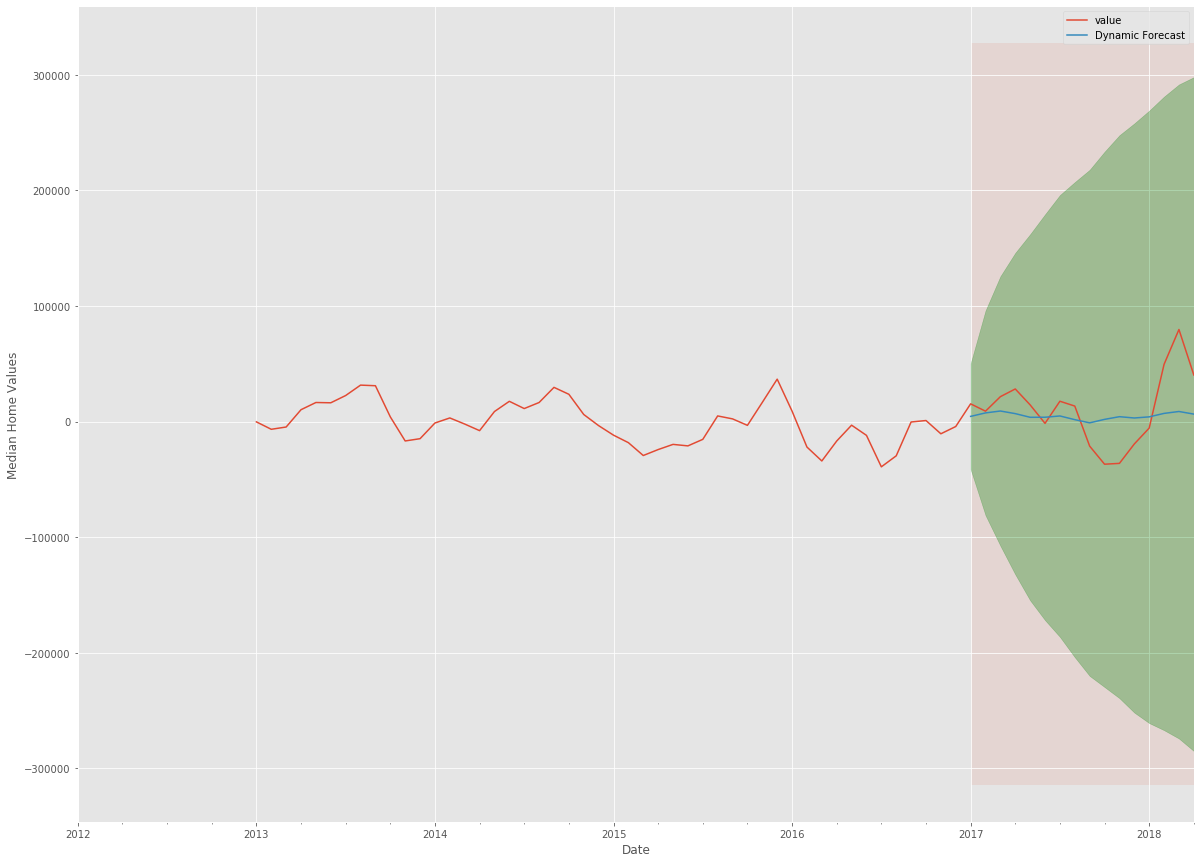

In [189]:
ax = two_one_seven['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [190]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_zero_five.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 475269117.66


### Visualizing Confidence Interval

In [191]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

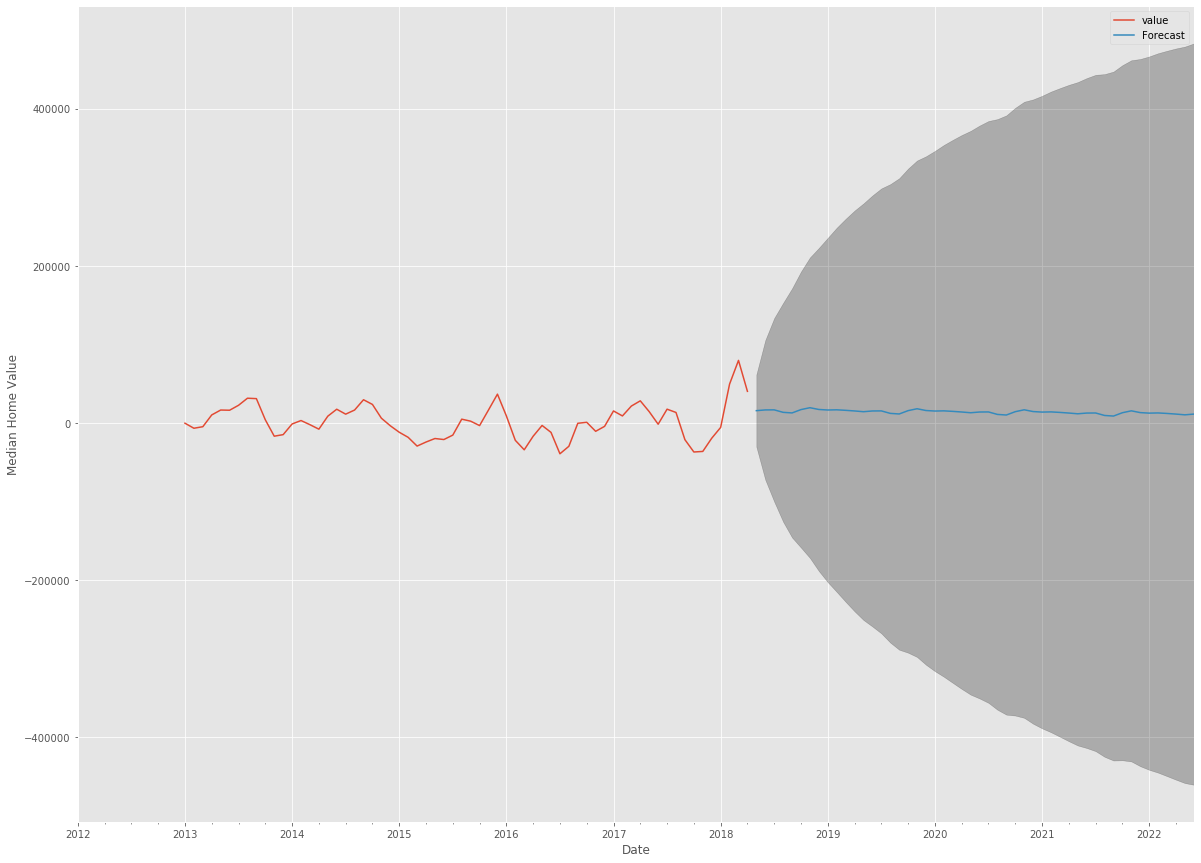

In [192]:
ax = two_one_seven.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11217 Conclusion: 

### 11228

In [193]:
two_two_eight = kings_grouped.loc[11228]

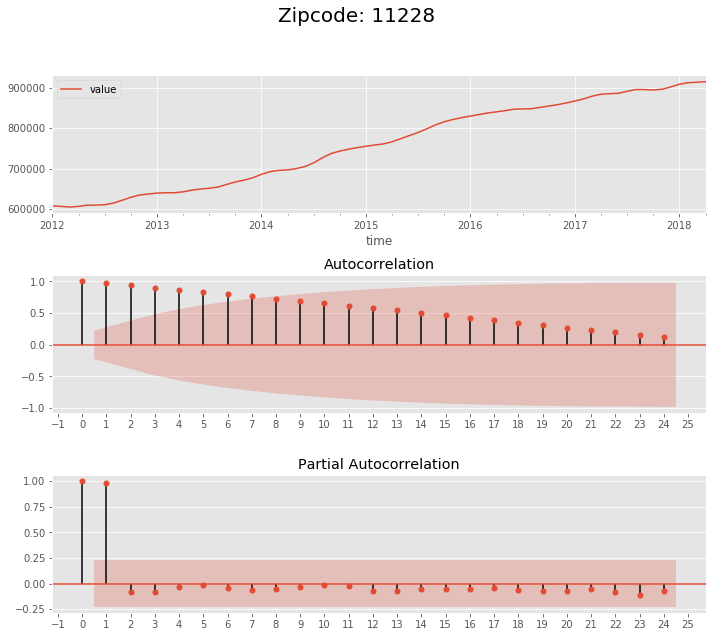

In [194]:
plot_acf_pacf(two_two_eight, zipcode = '11228')
plt.show()

### Decompose Time Series

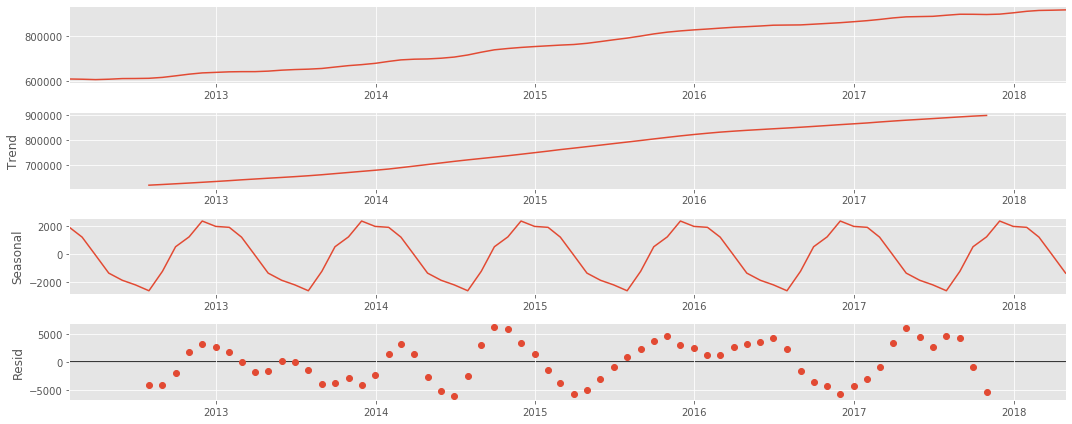

In [195]:
decompose_result = seasonal_decompose(two_two_eight, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

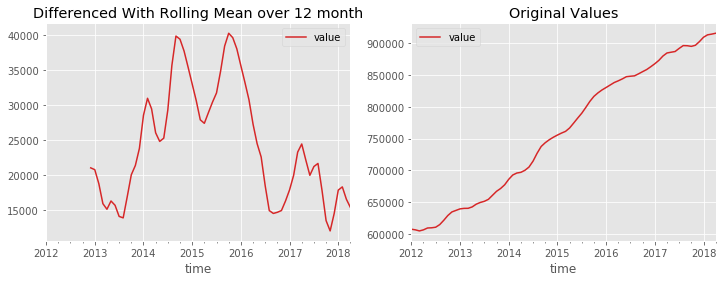

In [196]:
rolling_mean = two_two_eight.rolling(window = 12).mean()
two_two_eight_rolled_detrended = two_two_eight - rolling_mean

ax1 = plt.subplot(121)
two_two_eight_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_two_eight.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [197]:
dftest = adfuller(two_two_eight_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.5276212858327995
2. P-Value :  0.5198059382270369
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776


### Using Differencing with Mean Rolled Time Series for Seasonality

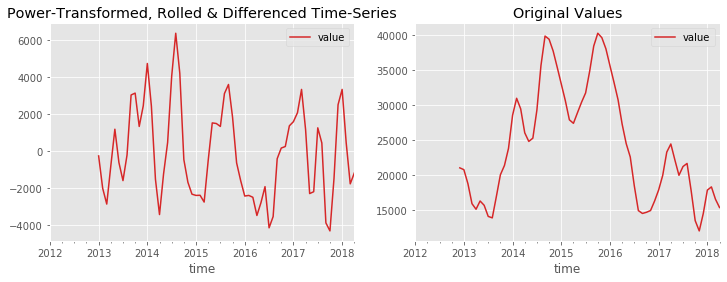

In [198]:
two_two_eight_rolled_detrended_diff = two_two_eight_rolled_detrended - two_two_eight_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_two_eight_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_two_eight_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [199]:
two_two_eight = two_two_eight_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

In [200]:
dftest = adfuller(two_two_eight.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.043074132437363
2. P-Value :  0.001201019801758593
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776


### Parameter Selection

In [201]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [202]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_two_eight, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [203]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           877.268
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

In [204]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_two_eight, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7015      0.145      4.852      0.000       0.418       0.985
ar.S.L12      -0.1270      0.246     -0.516      0.606      -0.610       0.356
ma.S.L12      -1.1199      0.918     -1.220      0.223      -2.920       0.680
sigma2       2.33e+06    2.7e+06      0.864      0.388   -2.96e+06    7.62e+06


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

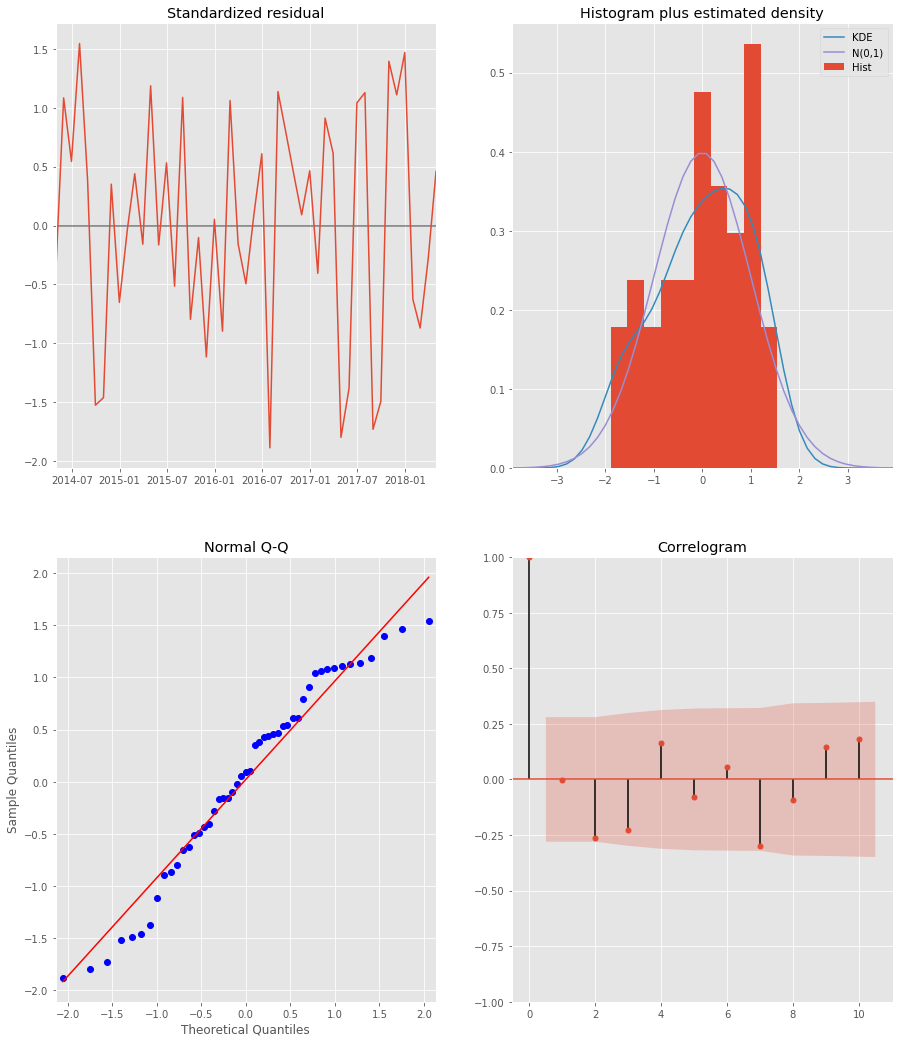

In [205]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [206]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

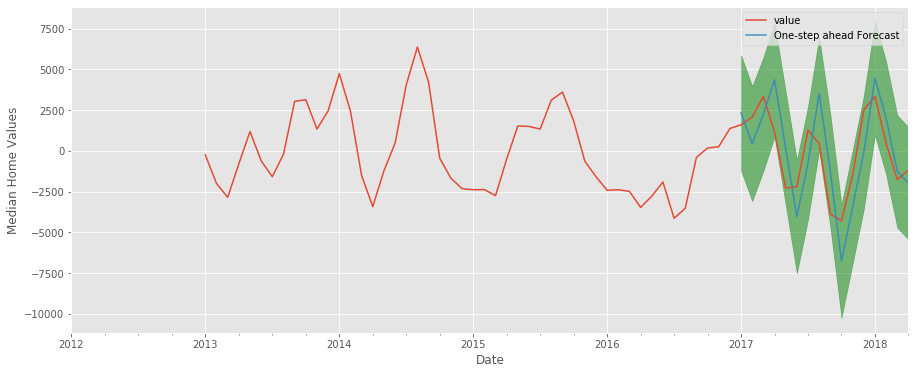

In [207]:

rcParams['figure.figsize'] = 15, 6

ax = two_two_eight['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [208]:
val_forecasted = pred.predicted_mean
val_truth = two_zero_five.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 520696056.38


### Model Validation - Dynamic Forecasting

In [209]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

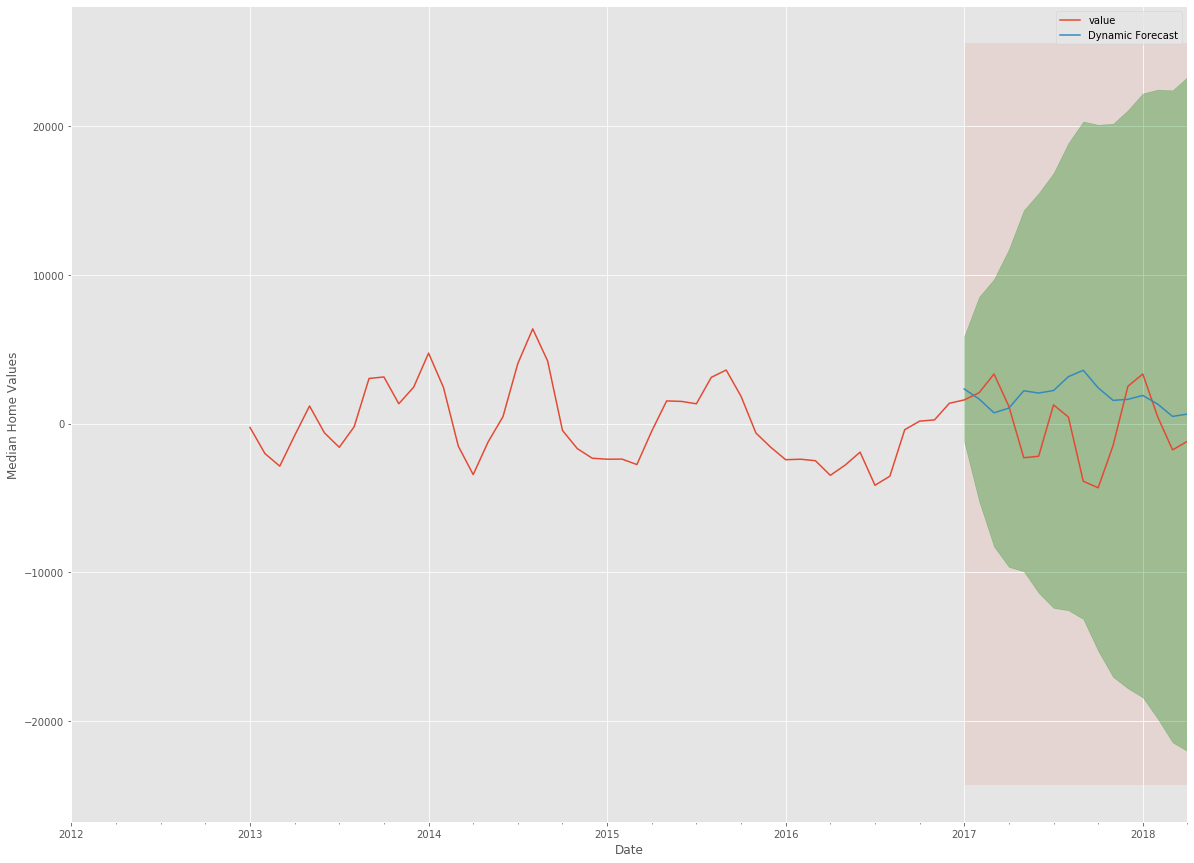

In [210]:
ax = two_two_eight['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [211]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_two_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 10998590.9


### Visualizing Confidence Interval

In [212]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

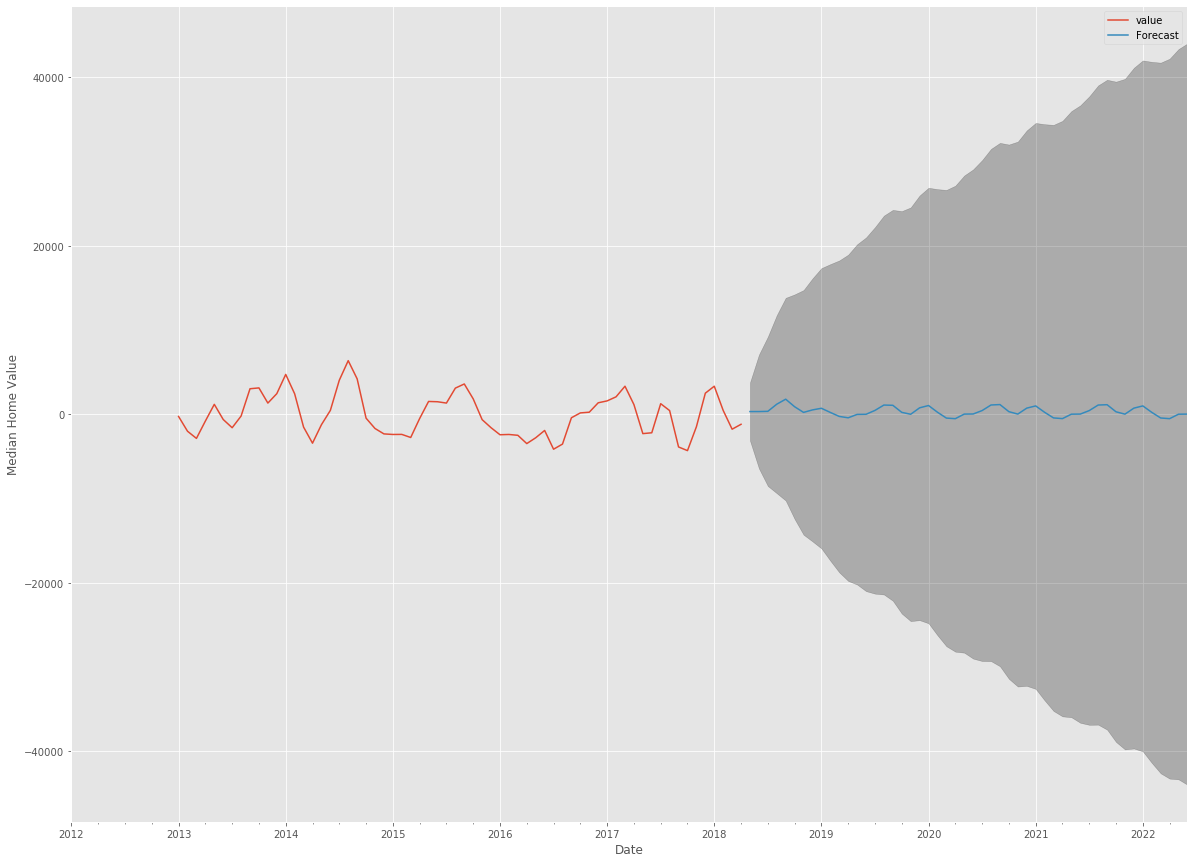

In [213]:
ax = two_two_eight.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()